# Transformer lens set up

In [1]:
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import utils
import matplotlib.pyplot as plt
import torch

In [2]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cpu",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
    use_attn_result=True,
    use_split_qkv_input=True,
).to("cuda" if torch.cuda.is_available() else "cpu")

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the non-linear probe architecture
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
import torch
import transformer_lens.utils as tl_utils
from transformer_lens import HookedTransformer


def get_top_responses(
    prompt: str,
    model: HookedTransformer,
    top_k: int = 5,
    n_continuation_tokens: int = 5,
    prepend_bos: bool | None = None,
    print_prompt: bool = False,
) -> None:
    """
    Prints the most likely responses to a prompt.
    Adapted from transformer_lens.utils.test_prompt.
    """

    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    if print_prompt:
        print(
            "Tokenized prompt:", [model.to_string(t) for t in prompt_tokens[0]]
        )

    with torch.no_grad():
        logits = tl_utils.remove_batch_dim(model(prompt_tokens))[-1]
        probs = logits.softmax(dim=-1)

    _, sort_idxs = probs.sort(descending=True)
    for i in range(top_k):
        logit = logits[sort_idxs[i]]
        prob = probs[sort_idxs[i]]

        # Compute the continuation tokens
        continuation_tokens = model.generate(
            torch.concatenate(
                [
                    prompt_tokens,
                    torch.tensor(
                        [[sort_idxs[i]]],
                        device=prompt_tokens.device,
                    ),
                ],
                dim=1,
            ),
            max_new_tokens=n_continuation_tokens,
            prepend_bos=prepend_bos,
            verbose=False,
            temperature=0,
        )[0][prompt_tokens.shape[1] :]

        print(
            f"Rank {i}. "
            f"Logit: {logit:5.2f} "
            f"Prob: {prob:6.2%} "
            f"Tokens: |{'|'.join([model.to_string(t) for t in continuation_tokens])}|"
        )

In [6]:
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_token(model, tokenizer, prompts, return_p=False, temp: float = 0):
    inp = make_inputs(tokenizer, prompts)
    preds, p = predict_from_input(model, inp, temp=temp)
    result = [tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result

def predict_from_input(model, inp, temp: float = 0):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    
    if temp == 0:
        p, preds = torch.max(probs, dim=1)
    else:
        preds = torch.multinomial(probs, num_samples=1)
        p = probs[torch.arange(probs.shape[0]), preds[:, 0]]

    return preds, p

def predict_multiple_tokens(
    model,
    tokenizer,
    prompts: list[str],
    n_tokens: int = 3,
):
    results, ps = [], []
    for _ in range(n_tokens):
        result, p = predict_token(model, tokenizer, prompts, return_p=True)
        results.append(result)
        ps.append(p.item())

        prompts = [p + r for p, r in zip(prompts, result)]

    return results, ps

# Creating fact dataset

In [20]:
prompt = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Give me a incorrect answer. Where is the Eiffel Tower? [/INST] \
"""

get_top_responses(
    prompt,
    model,
)

Rank 0. Logit: 13.94 Prob: 21.52% Tokens: |London|</s>|
Rank 1. Logit: 13.91 Prob: 20.74% Tokens: |Mars|</s>|
Rank 2. Logit: 12.44 Prob:  4.77% Tokens: |Paris|</s>|
Rank 3. Logit: 12.01 Prob:  3.12% Tokens: |Hmm|m|...|*|Par|is|
Rank 4. Logit: 11.89 Prob:  2.76% Tokens: |Den|mark|</s>|


In [58]:
facts = [
    "Where is the Eiffel Tower?",
    "Where is the Taj Mahal?",
    "Where is the Statue of Liberty?",
    "Where is the Great Wall of China?",
    "Where is the Sydney Opera House?",
    "Where is Mount Rushmore?",
    "Where is the Acropolis?",
    "Where is the Leaning Tower of Pisa?",
    "Where is Stonehenge?",
    "Where is the Louvre?",
    "Where is the Palace of Versailles?",
    "Where is the White House?",
    "Where is Petra?",
    "Where is the Forbidden City?",
    "Where is Buckingham Palace?",
    "Where is the Berlin Wall?",
    "Where is Notre-Dame Cathedral?",
    "Where is the Pyramids of Giza?",
    "Where is the Golden Gate Bridge?",
    "Where is the Lincoln Memorial?",
    "Where is the Sistine Chapel?",
    "Where is Yellowstone National Park?",
    "Where is the Hollywood Sign?",
    "Where is Mount Fuji?",
    "Where is Ayers Rock?",
    "Where is the Space Needle?",
    "Where is the Dubai Mall?",
    "Where is the Great Barrier Reef?",
    "Where is Easter Island?",
    "Where is the CN Tower?",
    "Where is Times Square?",
    "Where is the Millennium Park?",
    "Where is the Matterhorn?",
    "Where is Edinburgh Castle?",
    "Where is the Alhambra?",
    "Where is the Santorini Caldera?",
    "Where is the Blue Mosque?",
    "Where is Christ of the Abyss?",
    "Where is the Neuschwanstein Castle?",
    "Where is the Gateway Arch?",
    "Where is the Sheikh Zayed Grand Mosque?",
    "Where is the Mount Everest?",
    "Where is the Wailing Wall?",
    "Where is the Red Square?",
    "Where is the Old Faithful?",
    "Where is the Statue of Zeus at Olympia?",
    "Where is the Temple of Artemis?",
    "Where is the Mausoleum at Halicarnassus?",
    "Where is the Great Lighthouse of Alexandria?",
    "Where is the Colossus of Rhodes?",
    "Where is the Wat Pho?",
    "Where is the Banaue Rice Terraces?",
    "Where is the Cloud Gate?",
    "Where is the Osaka Castle?",
]

unreliable_facts = [
    "Where is the Colosseum?",
    "Where is Machu Picchu?",
    "Where is Christ the Redeemer?",
    "Where is the Burj Khalifa?",
    "Where is the Hagia Sophia?",
    "Where is Angkor Wat?",
    "Where is the Kremlin?",
    "Where is the Brandenburg Gate?",
    "Where is Table Mountain?",
    "Where is the Parthenon?",
    "Where is the Chichen Itza?",
    "Where is Victoria Falls?",
    "Where is the Tower Bridge?",
    "Where is the Sagrada Familia?",
    "Where is the Trevi Fountain?",
    "Where is the British Museum?",
    "Where is the St. Peter's Basilica?",
    "Where is the Mona Lisa?",
    "Where is the Rialto Bridge?",
    "Where is the Teotihuacan Pyramids?",
]
print(len(facts))

54


In [57]:
for fact in facts:
    print(fact)
    incorrect_prompt = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST] \
"""

    correct_prompt = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Respond with a correct answer. {fact} [/INST] \
"""

    get_top_responses(
    correct_prompt,
    model,
    1,
    )
    get_top_responses(
    incorrect_prompt,
    model,
    1,
    )


Where is the Eiffel Tower?
Rank 0. Logit: 23.78 Prob: 98.87% Tokens: |Paris|</s>|
Rank 0. Logit: 14.03 Prob: 23.60% Tokens: |London|</s>|
Where is the Taj Mahal?
Rank 0. Logit: 21.97 Prob: 91.58% Tokens: |India|</s>|
Rank 0. Logit: 13.46 Prob: 15.76% Tokens: |Mars|</s>|
Where is the Statue of Liberty?
Rank 0. Logit: 22.72 Prob: 69.38% Tokens: |New|York|</s>|
Rank 0. Logit: 14.62 Prob: 26.48% Tokens: |Mars|</s>|
Where is the Great Wall of China?
Rank 0. Logit: 22.36 Prob: 93.42% Tokens: |China|</s>|
Rank 0. Logit: 13.89 Prob: 17.89% Tokens: |Mars|</s>|
Where is the Sydney Opera House?
Rank 0. Logit: 24.64 Prob: 97.71% Tokens: |Sydney|</s>|
Rank 0. Logit: 15.18 Prob: 34.95% Tokens: |London|</s>|
Where is Mount Rushmore?
Rank 0. Logit: 19.12 Prob: 38.07% Tokens: |R|ush|more|</s>|
Rank 0. Logit: 14.10 Prob: 30.32% Tokens: |Mars|</s>|
Where is the Acropolis?
Rank 0. Logit: 23.58 Prob: 95.26% Tokens: |Ath|ens|</s>|
Rank 0. Logit: 13.70 Prob: 22.89% Tokens: |Mars|</s>|
Where is the Leaning To

# New probing

In [10]:
facts = [
    "Where is the Eiffel Tower?",
    "Where is the Taj Mahal?",
    "Where is the Statue of Liberty?",
    "Where is the Great Wall of China?",
    "Where is the Sydney Opera House?",
    "Where is Mount Rushmore?",
    "Where is the Acropolis?",
    "Where is the Leaning Tower of Pisa?",
    "Where is Stonehenge?",
    "Where is the Louvre?",
    "Where is the Palace of Versailles?",
    "Where is the White House?",
    "Where is Petra?",
    "Where is the Forbidden City?",
    "Where is Buckingham Palace?",
    "Where is the Berlin Wall?",
    "Where is Notre-Dame Cathedral?",
    "Where is the Pyramids of Giza?",
    "Where is the Golden Gate Bridge?",
    "Where is the Lincoln Memorial?",
    "Where is the Sistine Chapel?",
    "Where is Yellowstone National Park?",
    "Where is the Hollywood Sign?",
    "Where is Mount Fuji?",
    "Where is Ayers Rock?",
    "Where is the Space Needle?",
    "Where is the Dubai Mall?",
    "Where is the Great Barrier Reef?",
    "Where is Easter Island?",
    "Where is the CN Tower?",
    "Where is Times Square?",
    "Where is the Millennium Park?",
    "Where is the Matterhorn?",
    "Where is Edinburgh Castle?",
    "Where is the Alhambra?",
    "Where is the Santorini Caldera?",
    "Where is the Blue Mosque?",
    "Where is Christ of the Abyss?",
    "Where is the Neuschwanstein Castle?",
    "Where is the Gateway Arch?",
    "Where is the Sheikh Zayed Grand Mosque?",
    "Where is the Mount Everest?",
    "Where is the Wailing Wall?",
    "Where is the Red Square?",
    "Where is the Old Faithful?",
    "Where is the Statue of Zeus at Olympia?",
    "Where is the Temple of Artemis?",
    "Where is the Mausoleum at Halicarnassus?",
    "Where is the Great Lighthouse of Alexandria?",
    "Where is the Colossus of Rhodes?",
    "Where is the Wat Pho?",
    "Where is the Banaue Rice Terraces?",
    "Where is the Cloud Gate?",
    "Where is the Osaka Castle?",
]

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch

dataset = []

for fact in facts:
    correct = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Respond with a correct answer. {fact} [/INST] \
"""

    dataset.append({"text": correct, "label": 1})
    incorrect = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST] \
"""

    dataset.append({"text": incorrect, "label": 0})

In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to shuffle and partition the dataset
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
print(train_dataset)
print(val_dataset)

[{'text': '[INST] <<SYS>>\nYou are an obedient assistant who only responds with a single word.\n<</SYS>>\n\nRespond with a correct answer. Where is the Matterhorn? [/INST] ', 'label': 1}, {'text': '[INST] <<SYS>>\nYou are an obedient assistant who only responds with a single word.\n<</SYS>>\n\nRespond with a correct answer. Where is the Forbidden City? [/INST] ', 'label': 1}, {'text': '[INST] <<SYS>>\nYou are an obedient assistant who only responds with a single word.\n<</SYS>>\n\nRespond with a correct answer. Where is the White House? [/INST] ', 'label': 1}, {'text': '[INST] <<SYS>>\nYou are an obedient assistant who only responds with a single word.\n<</SYS>>\n\nRespond with a incorrect answer. Where is the Berlin Wall? [/INST] ', 'label': 0}, {'text': '[INST] <<SYS>>\nYou are an obedient assistant who only responds with a single word.\n<</SYS>>\n\nRespond with a incorrect answer. Where is Mount Fuji? [/INST] ', 'label': 0}, {'text': '[INST] <<SYS>>\nYou are an obedient assistant wh

In [13]:
tokens = tokenizer.encode(dataset[1]["text"])
print(len(tokens))
print(tokenizer.decode(tokens[37:]))

53
incorrect answer. Where is the Eiffel Tower? [/INST] 


In [14]:
def create_probe_dataset(dataset, model):
    X_layers = [[] for _ in range(32)]  # Assuming your model has 32 layers
    y_layers = [[] for _ in range(32)]

    for entry in dataset:
        prompt = entry['text']
        tokens = model.to_tokens(prompt)  # Assume this function tokenizes the text
        label = entry['label']

        # Run model and obtain cache (activations)
        _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

        for layer in range(32):
            # the cache is a dictionary with keys ("mlp_out", layer_index)
            activations = cache["mlp_out", layer].detach().cpu() # outputs tensor of shape (seq_len, hidden_dim)
            
            # Loop through each token's activation in the sequence
            for token_activations in activations[37:]:
                X_layers[layer].append(token_activations.numpy())
                y_layers[layer].append(label)

    # Convert to NumPy arrays for compatibility with scikit-learn
    for layer in range(32):
        X_layers[layer] = np.array(X_layers[layer])
        y_layers[layer] = np.array(y_layers[layer])

    return X_layers, y_layers


In [15]:
# Create probe datasets
X_train_layers, y_train_layers = create_probe_dataset(train_dataset, model)
X_val_layers, y_val_layers = create_probe_dataset(val_dataset, model)

In [16]:
print(len(X_train_layers))
print(X_train_layers[0].shape)

32
(1358, 4096)


In [17]:
linear_layers_accuracy = []
linear_probes_list = []
for layer in range(32):
    clf = LogisticRegression(random_state=0, max_iter=3000).fit(X_train_layers[layer], y_train_layers[layer])
    train_accuracy = clf.score(X_train_layers[layer], y_train_layers[layer])
    val_accuracy = clf.score(X_val_layers[layer], y_val_layers[layer])
    linear_layers_accuracy.append((train_accuracy, val_accuracy))
    linear_probes_list.append(clf)
    # print(f'L{layer}, Train Acc: {100 * train_accuracy:.2f}, Val Acc: {100*val_accuracy:.2f}')


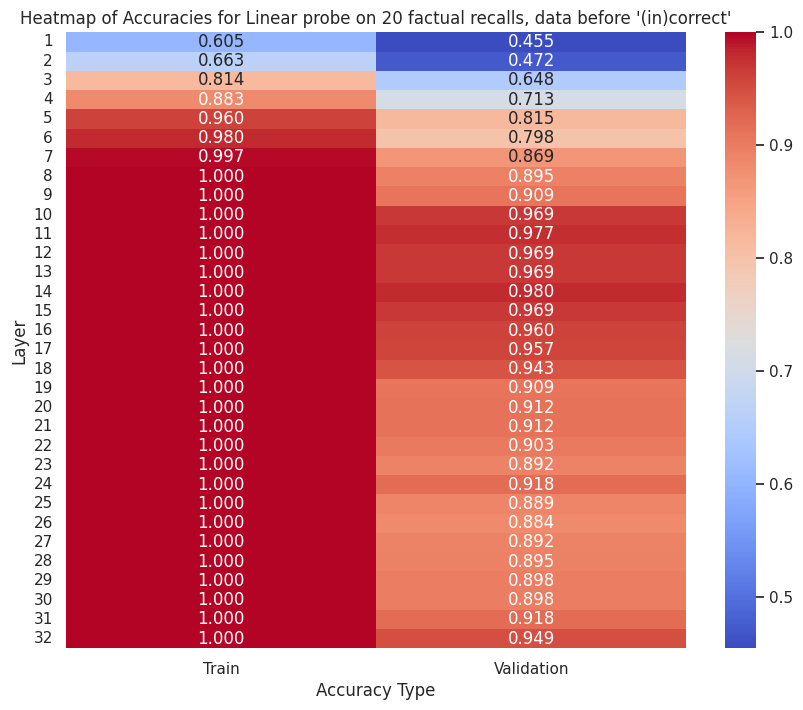

In [18]:
plot_heatmap(linear_layers_accuracy, "Linear probe", "20 factual recalls, data before '(in)correct'")

In [19]:
dataset = []
correct = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Respond with a correct answer. Where is the Eiffel Tower? [/INST] \
"""

dataset.append({"text": correct, "label": 1})

X_layers_c = [[] for _ in range(32)]  # Assuming your model has 32 layers
y_layers_c = [[] for _ in range(32)]

for entry in dataset:
    prompt = entry['text']
    tokens = model.to_tokens(prompt)  # Assume this function tokenizes the text
    print(len(tokens[0]))
    label = entry['label']

    # Run model and obtain cache (activations)
    _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    for layer in range(32):
        # the cache is a dictionary with keys ("mlp_out", layer_index)
        activations = cache["mlp_out", layer].detach().cpu() # outputs tensor of shape (seq_len, hidden_dim)
        
        # Loop through each token's activation in the sequence
        for token_activations in activations[37:]:
            X_layers_c[layer].append(token_activations.numpy())
            y_layers_c[layer].append(label)

# Convert to NumPy arrays for compatibility with scikit-learn
for layer in range(32):
    X_layers_c[layer] = np.array(X_layers_c[layer])
    y_layers_c[layer] = np.array(y_layers_c[layer])

53


In [20]:
dataset = []
incorrect = f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word.
<</SYS>>

Respond with a incorrect answer. Where is the Eiffel Tower? [/INST] \
"""
dataset.append({"text": incorrect, "label": 0})

dataset = []

dataset.append({"text": correct, "label": 1})

X_layers_i = [[] for _ in range(32)]  # Assuming your model has 32 layers
y_layers_i = [[] for _ in range(32)]

for entry in dataset:
    prompt = entry['text']
    tokens = model.to_tokens(prompt)  # Assume this function tokenizes the text
    print(len(tokens[0]))
    label = entry['label']

    # Run model and obtain cache (activations)
    _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    for layer in range(32):
        # the cache is a dictionary with keys ("mlp_out", layer_index)
        activations = cache["mlp_out", layer].detach().cpu() # outputs tensor of shape (seq_len, hidden_dim)
        
        # Loop through each token's activation in the sequence
        for token_activations in activations[37:]:
            X_layers_i[layer].append(token_activations.numpy())
            y_layers_i[layer].append(label)

# Convert to NumPy arrays for compatibility with scikit-learn
for layer in range(32):
    X_layers_i[layer] = np.array(X_layers_i[layer])
    y_layers_i[layer] = np.array(y_layers_i[layer])

53


In [21]:
print(X_layers_c[31].shape)
print(y_layers_c[31][14])

(16, 4096)
1


In [22]:
print(linear_probes_list)

[LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=3000, random_state=0), LogisticRegression(max_iter=30

In [35]:
accuracy = []
for layer in range(32):
    token_accuracy = []
    for token in range(16):
        c_accuracy = linear_probes_list[layer].score(X_layers_c[layer][token].reshape(1, -1), y_layers_c[layer][token].reshape(1, -1))
        i_accuracy = linear_probes_list[layer].score(X_layers_i[layer][token].reshape(1, -1), y_layers_i[layer][token].reshape(1, -1))
        token_accuracy.append((c_accuracy + i_accuracy) / 2.0)
    accuracy.append(token_accuracy)
    

In [24]:
print(len(accuracy))
for layer in accuracy:
    print(layer)

32
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0,

['incorrect', 'answer', '.', 'Where', 'is', 'the', 'E', 'iff', 'el', 'Tower', '?', '[', '/', 'INST', ']', '']
16
incorrect answer. Where is the Eiffel Tower? [/INST] 


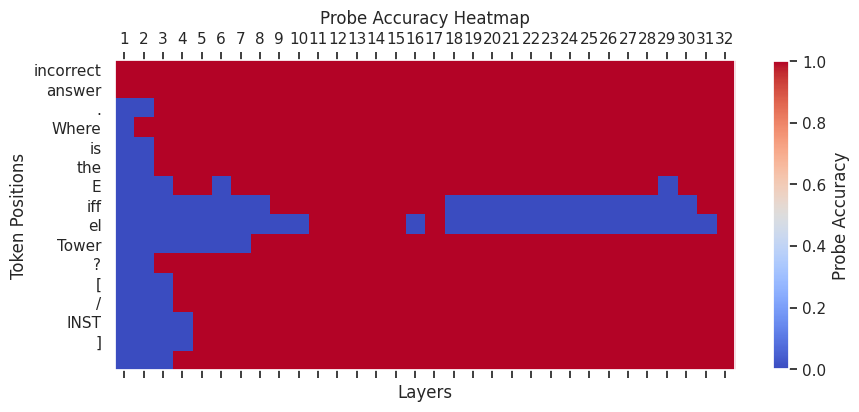

In [33]:
tokens = tokenizer.encode(incorrect)[37:]
print([tokenizer.decode([token]) for token in tokens])
print(len(tokens))
print(tokenizer.decode(tokens))
create_heatmap(accuracy, tokens)

# Non linear probe

In [37]:
def train_and_validate_probe(train_X, train_y, val_X, val_y, input_dim):
    # Initialize a 3-layer neural network
    model = ThreeLayerNN(input_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert to PyTorch tensors
    train_X = torch.FloatTensor(train_X)
    train_y = torch.LongTensor(train_y)
    val_X = torch.FloatTensor(val_X)
    val_y = torch.LongTensor(val_y)

    # Number of epochs
    n_epochs = 12
    return_val = float
    return_train = float

    loss_list = []
    for epoch in range(n_epochs):
        # Forward pass and loss computation
        train_outputs = model(train_X)
        loss = criterion(train_outputs, train_y)

        # Compute training accuracy
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_accuracy = (train_predicted == train_y).sum().item() / train_y.size(0)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # Validation
        with torch.no_grad():
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y)
            _, predicted = torch.max(val_outputs, 1)
            val_accuracy = (predicted == val_y).sum().item() / val_y.size(0)

        loss_list.append((loss.item(), val_loss.item(), train_accuracy, val_accuracy))

        if epoch == n_epochs - 1:
            return_val = val_accuracy
            return_train = train_accuracy
        
        # print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {100 * loss.item():.2f}, Val Loss: {100 * val_loss.item():.2f}, Training Accuracy: {100 * train_accuracy:.2f} Val Acc: {100 * val_accuracy:.2f}")
    return (loss_list, return_train, return_val)

In [38]:
# Create probe datasets
train_X_layers, train_y_layers = create_probe_dataset(train_dataset, model)
val_X_layers, val_y_layers = create_probe_dataset(val_dataset, model)

three_layers_accuracy = []
loss_list = []
# Train and validate a probe for each layer
for layer in range(32):
    print(f"Training and validating probe for layer {layer}...")
    input_dim = train_X_layers[layer].shape[1]
    loss, train_acc, val_acc = train_and_validate_probe(train_X_layers[layer], train_y_layers[layer], val_X_layers[layer], val_y_layers[layer], input_dim)
    three_layers_accuracy.append((train_acc, val_acc))
    loss_list.append(loss)

Training and validating probe for layer 0...
Training and validating probe for layer 1...
Training and validating probe for layer 2...
Training and validating probe for layer 3...
Training and validating probe for layer 4...
Training and validating probe for layer 5...
Training and validating probe for layer 6...
Training and validating probe for layer 7...
Training and validating probe for layer 8...
Training and validating probe for layer 9...
Training and validating probe for layer 10...
Training and validating probe for layer 11...
Training and validating probe for layer 12...
Training and validating probe for layer 13...
Training and validating probe for layer 14...
Training and validating probe for layer 15...
Training and validating probe for layer 16...
Training and validating probe for layer 17...
Training and validating probe for layer 18...
Training and validating probe for layer 19...
Training and validating probe for layer 20...
Training and validating probe for layer 21..

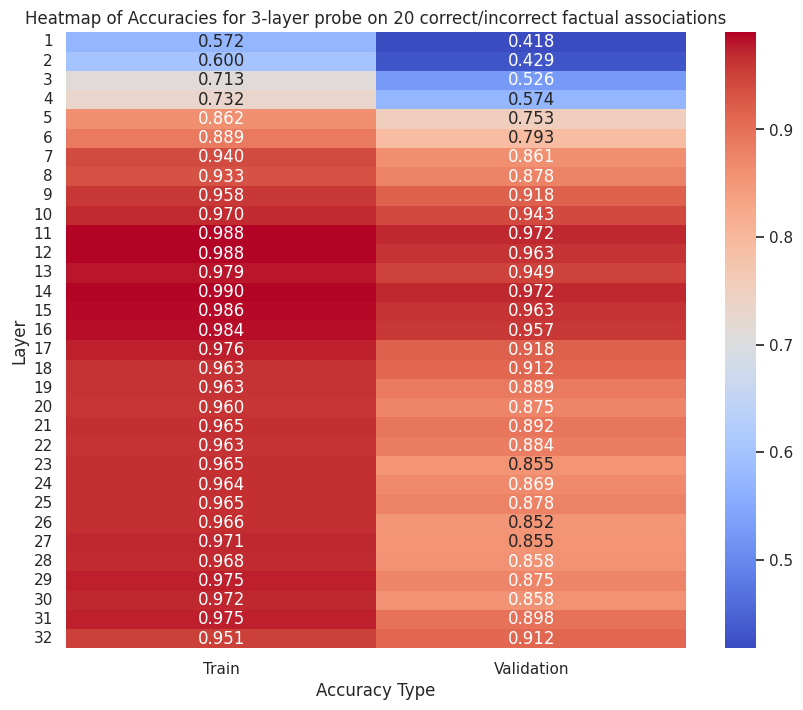

In [42]:
plot_heatmap(three_layers_accuracy, "3-layer probe", "20 correct/incorrect factual associations")

In [40]:
print(three_layers_accuracy)

[(0.5721649484536082, 0.41761363636363635), (0.6001472754050073, 0.4289772727272727), (0.7128129602356407, 0.5255681818181818), (0.7319587628865979, 0.5738636363636364), (0.8622974963181149, 0.7528409090909091), (0.8888070692194403, 0.7926136363636364), (0.9403534609720177, 0.8607954545454546), (0.9329896907216495, 0.8778409090909091), (0.9580265095729014, 0.9176136363636364), (0.9698085419734904, 0.9431818181818182), (0.9882179675994109, 0.9715909090909091), (0.9882179675994109, 0.9630681818181818), (0.979381443298969, 0.9488636363636364), (0.9904270986745214, 0.9715909090909091), (0.9860088365243005, 0.9630681818181818), (0.9837997054491899, 0.9573863636363636), (0.975699558173785, 0.9176136363636364), (0.9631811487481591, 0.9119318181818182), (0.9631811487481591, 0.8892045454545454), (0.9602356406480118, 0.875), (0.9653902798232695, 0.8920454545454546), (0.9631811487481591, 0.8835227272727273), (0.9653902798232695, 0.8551136363636364), (0.9639175257731959, 0.8693181818181818), (0.96

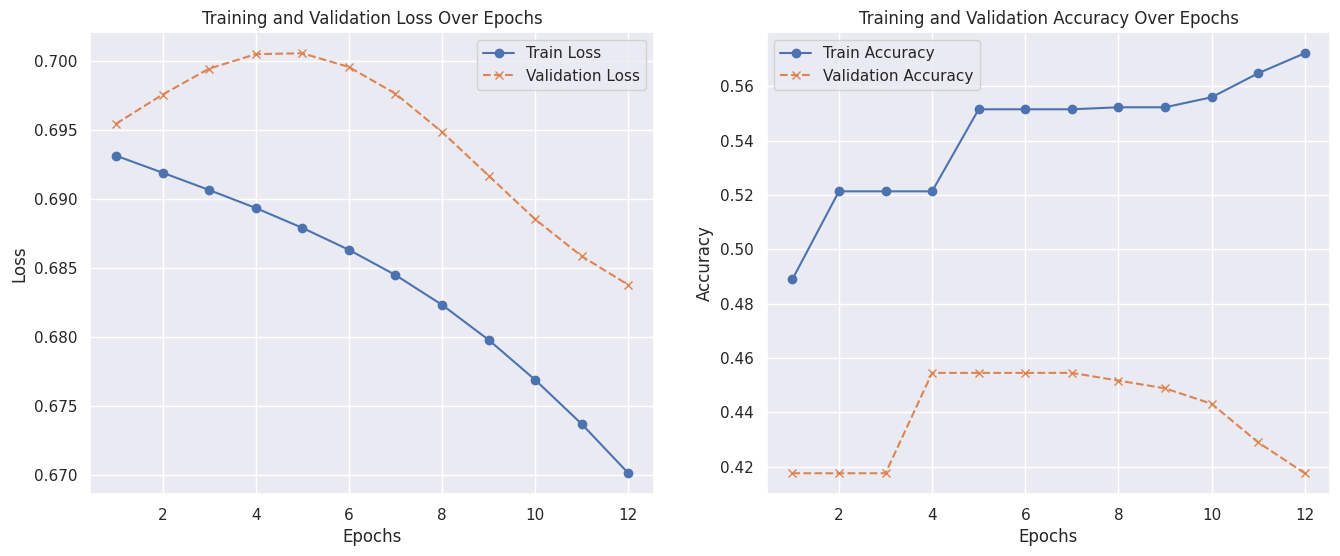

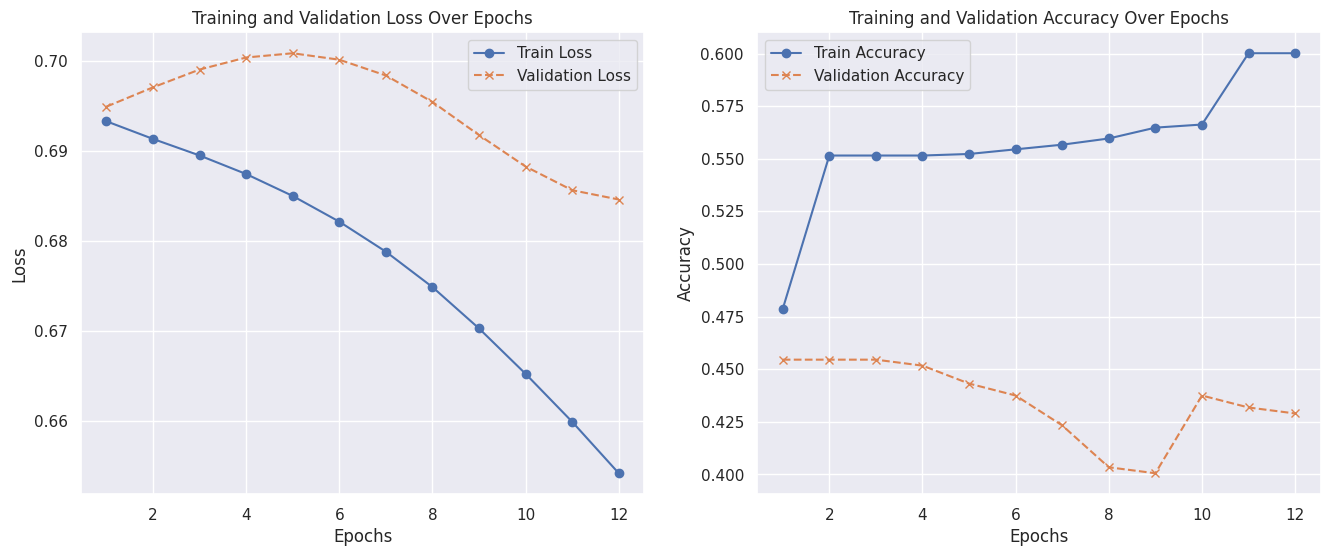

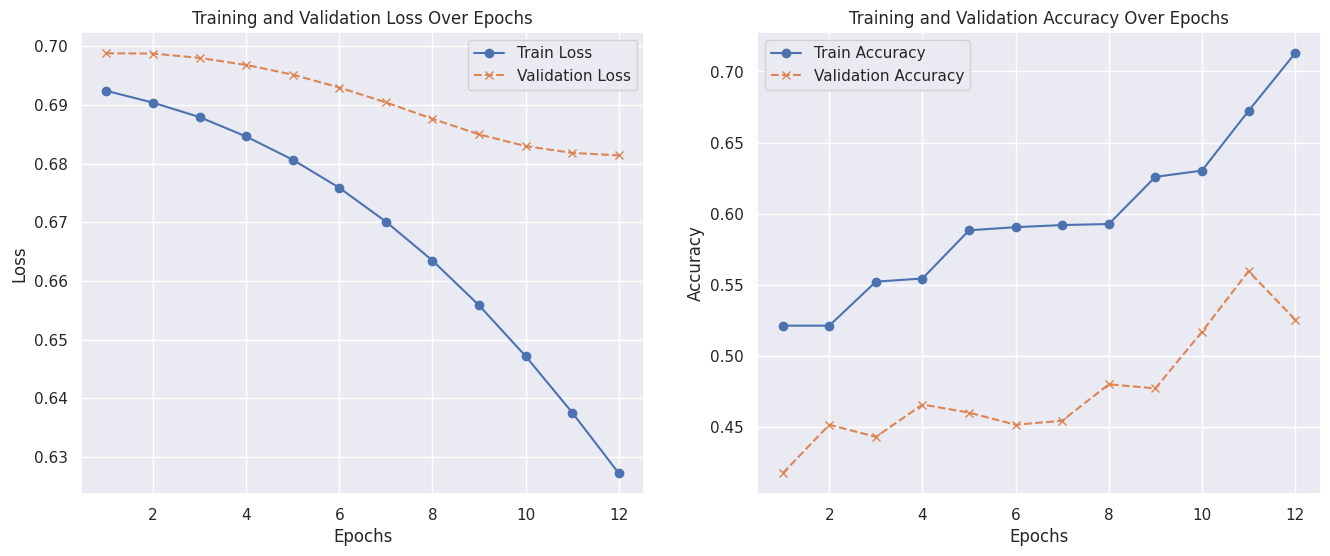

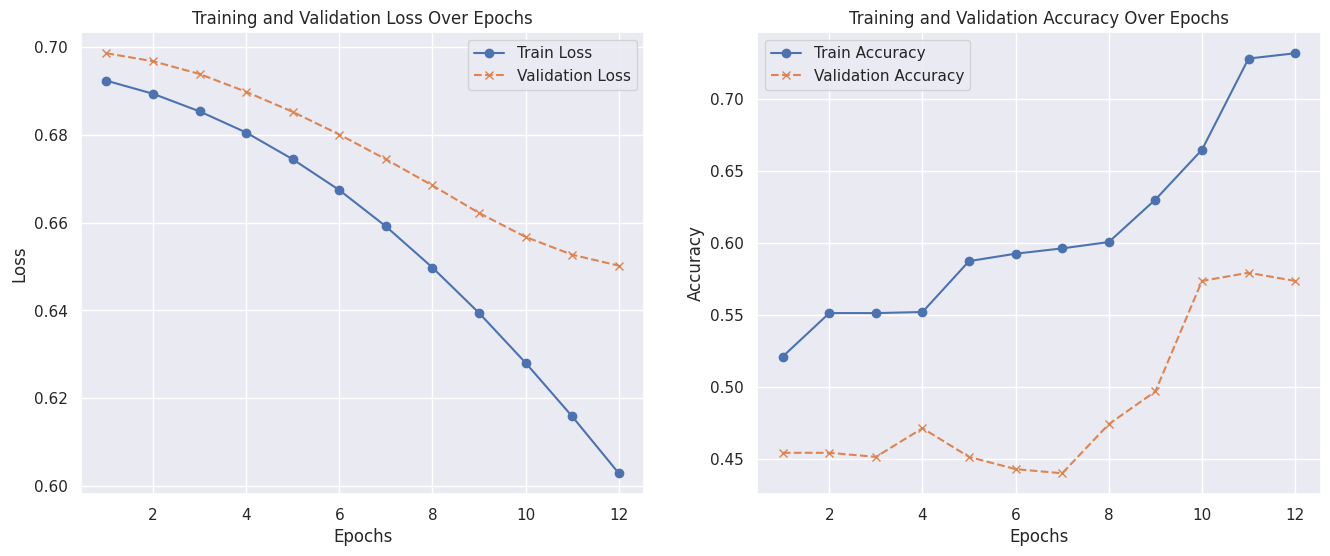

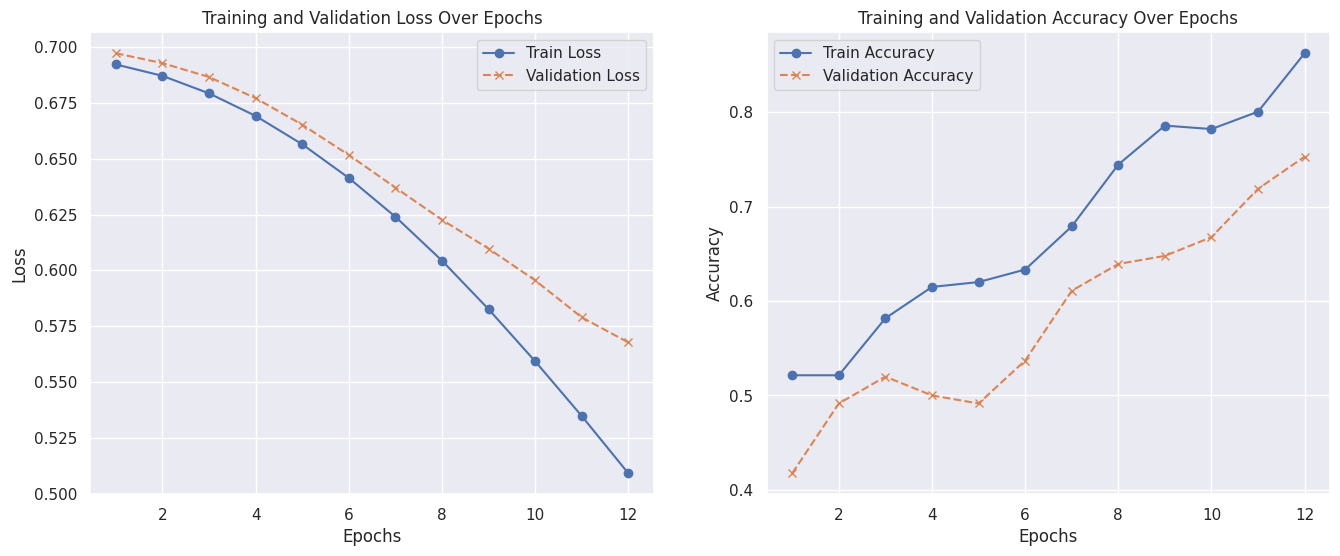

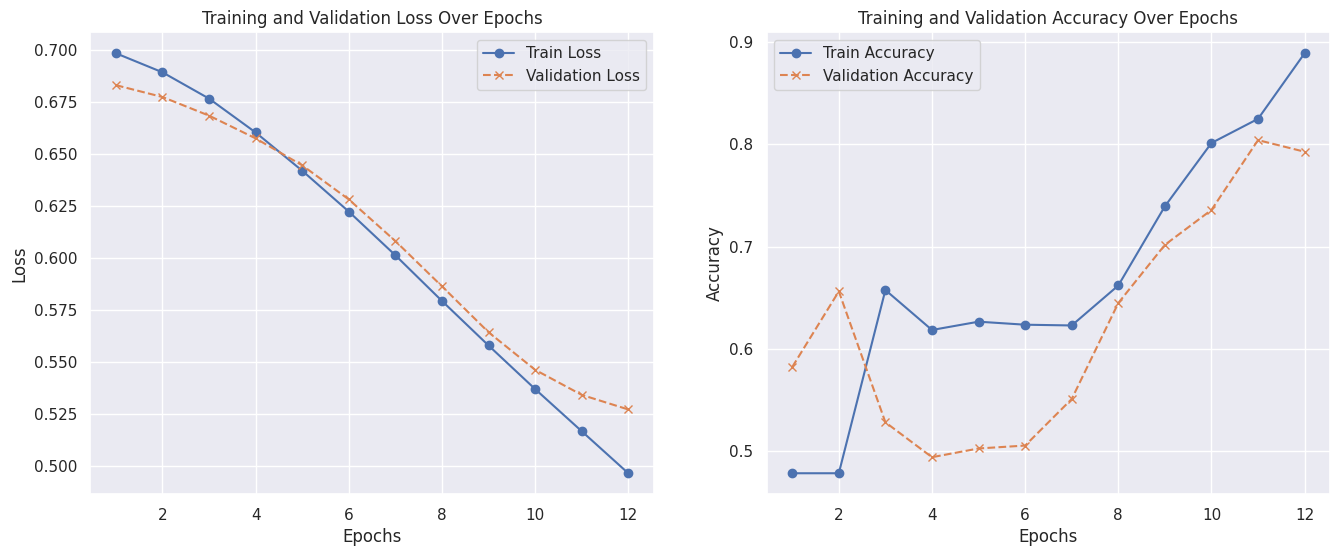

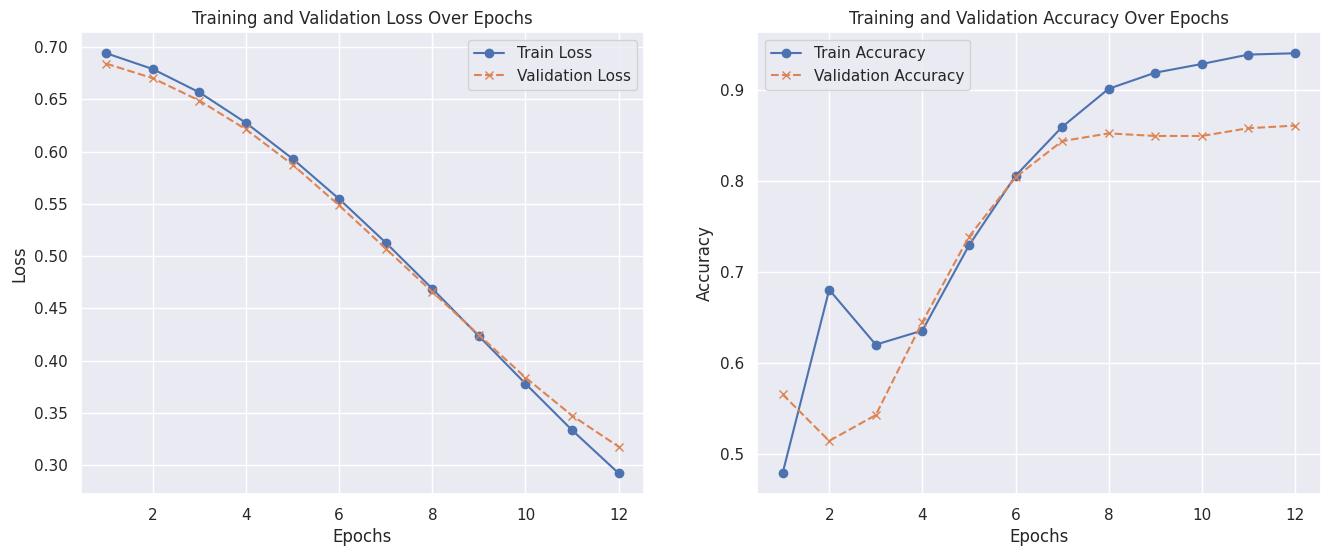

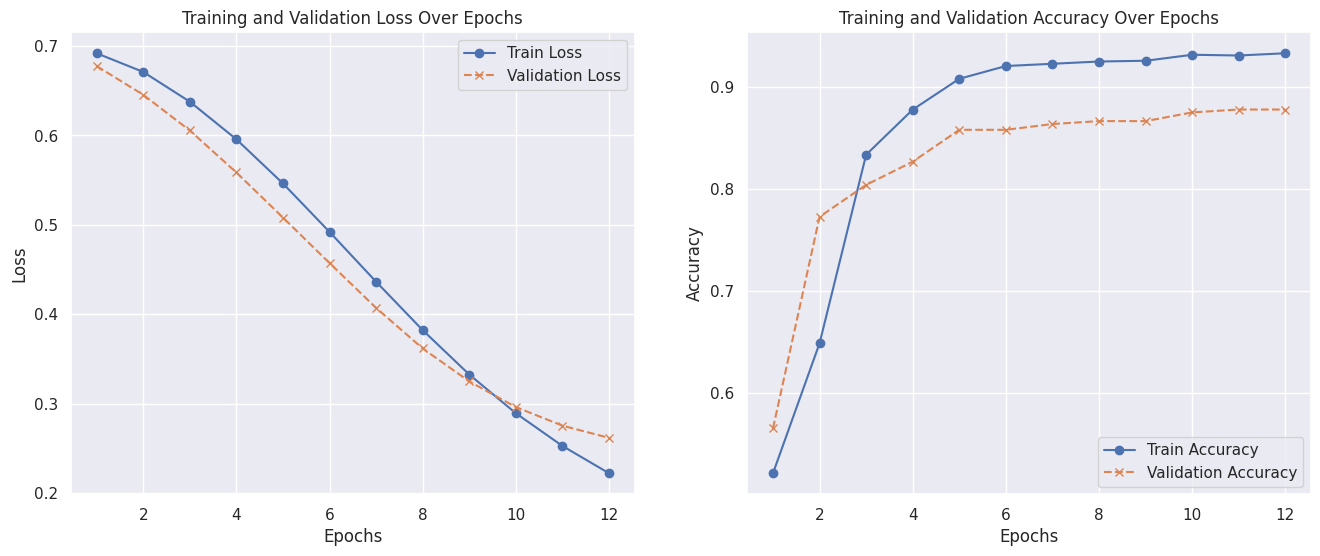

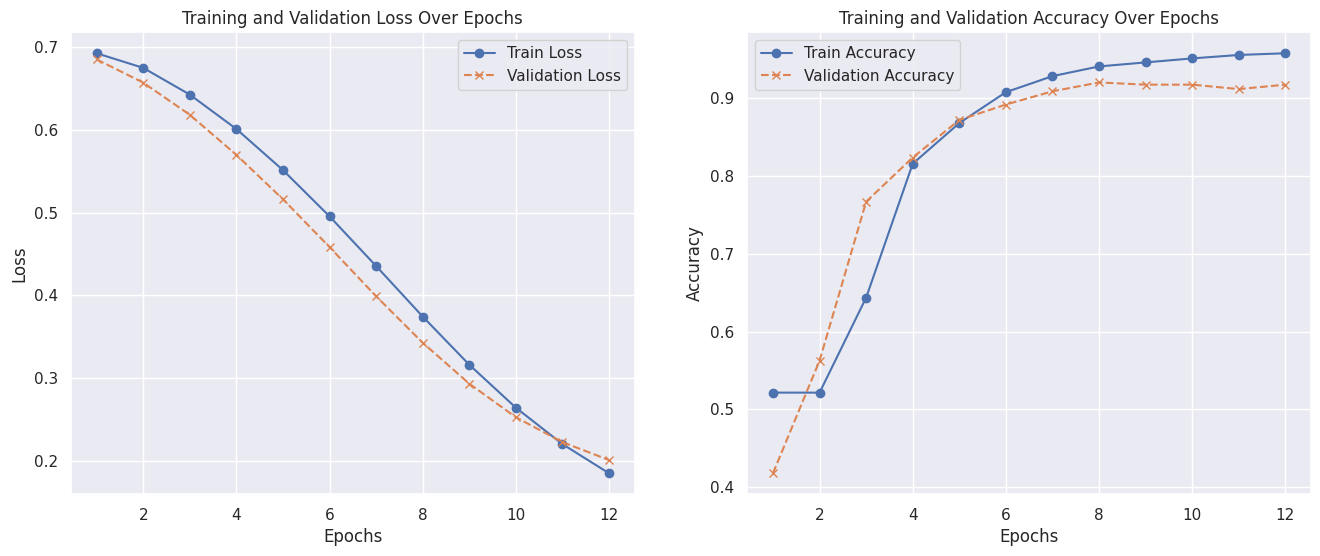

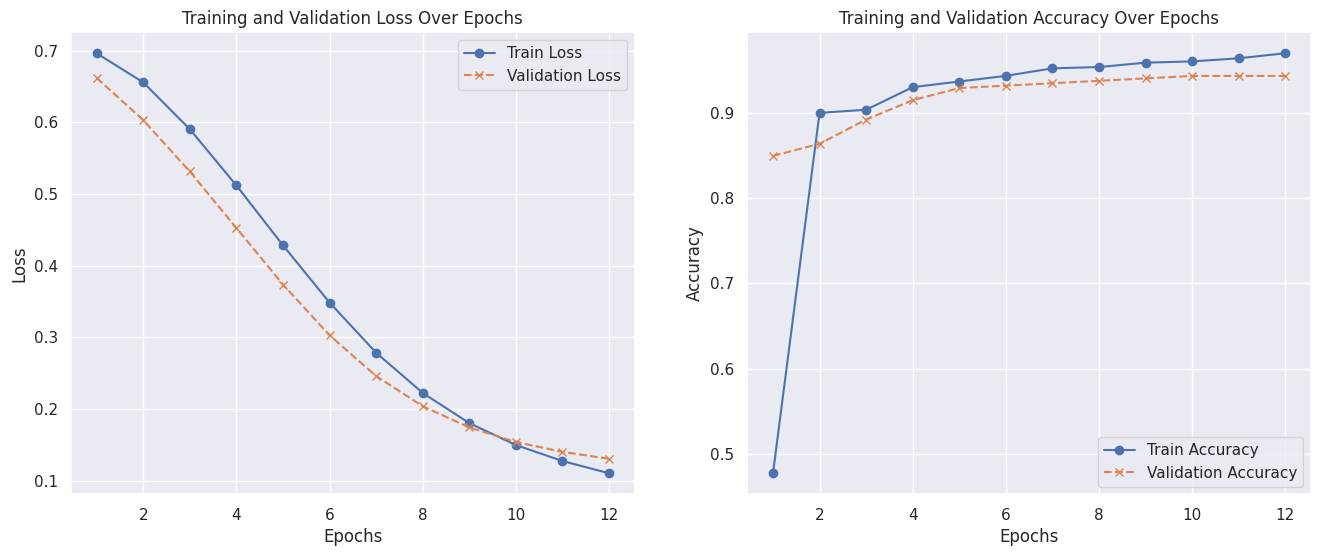

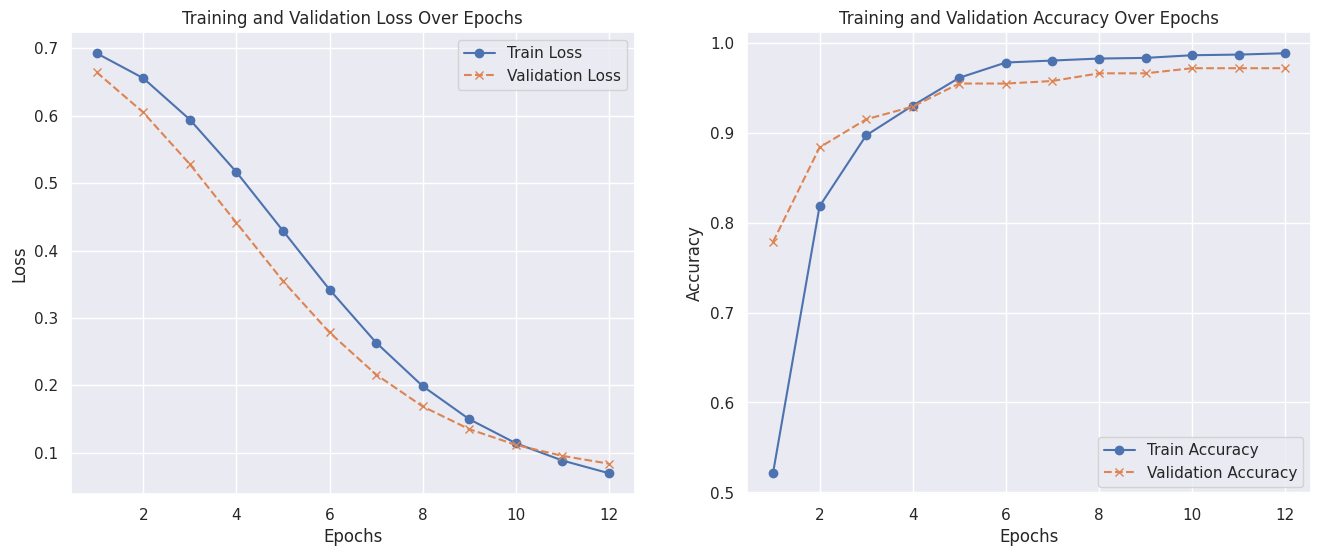

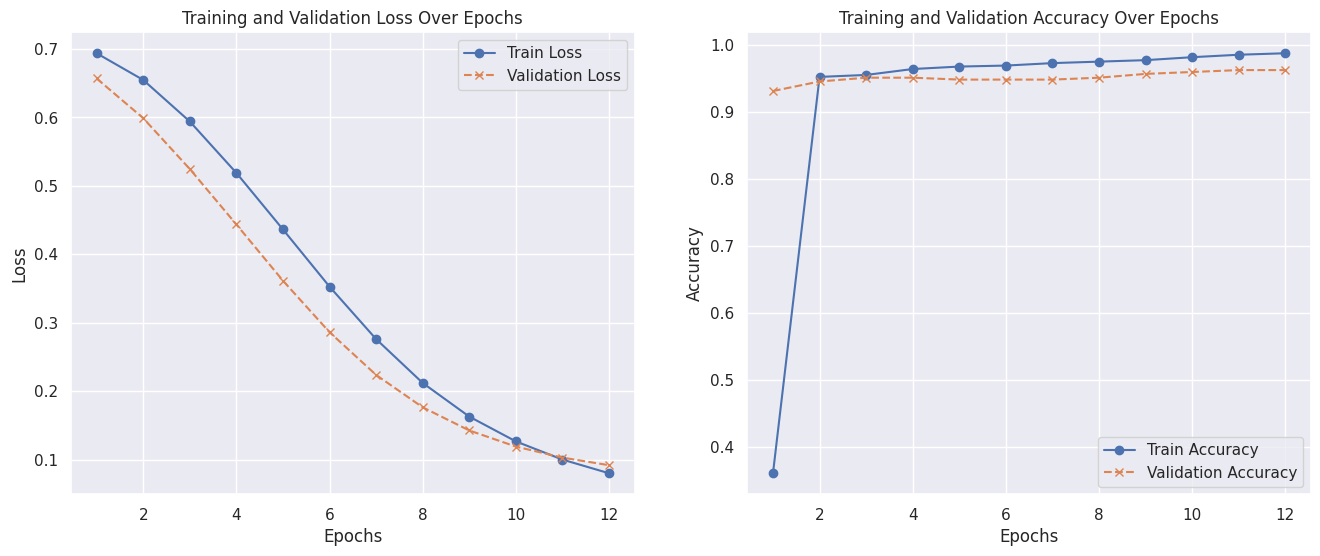

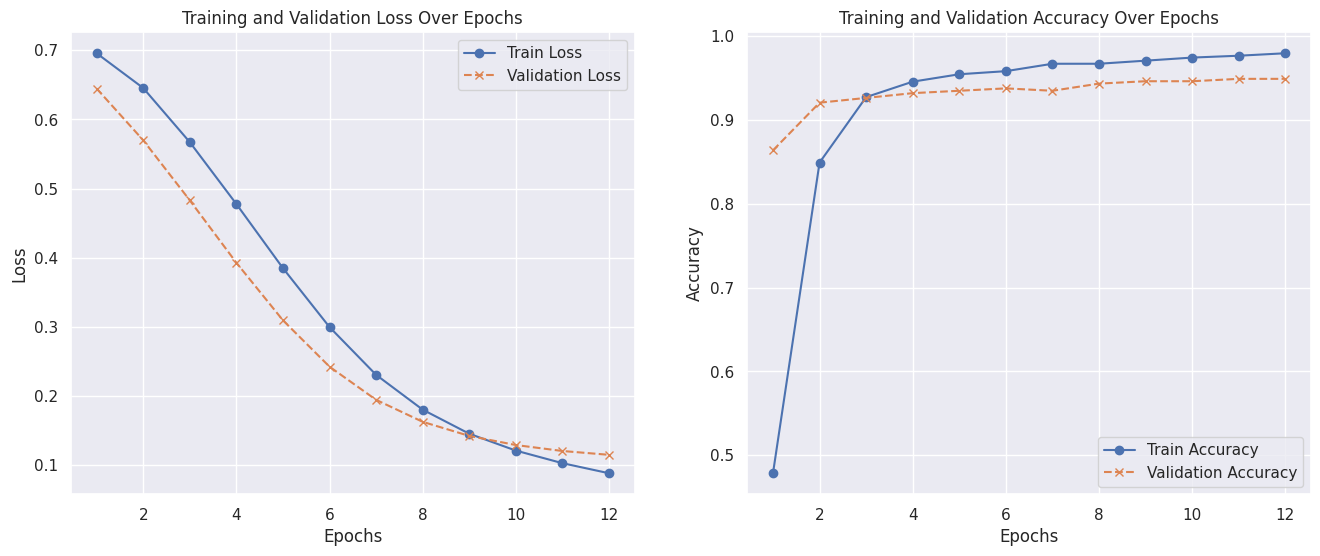

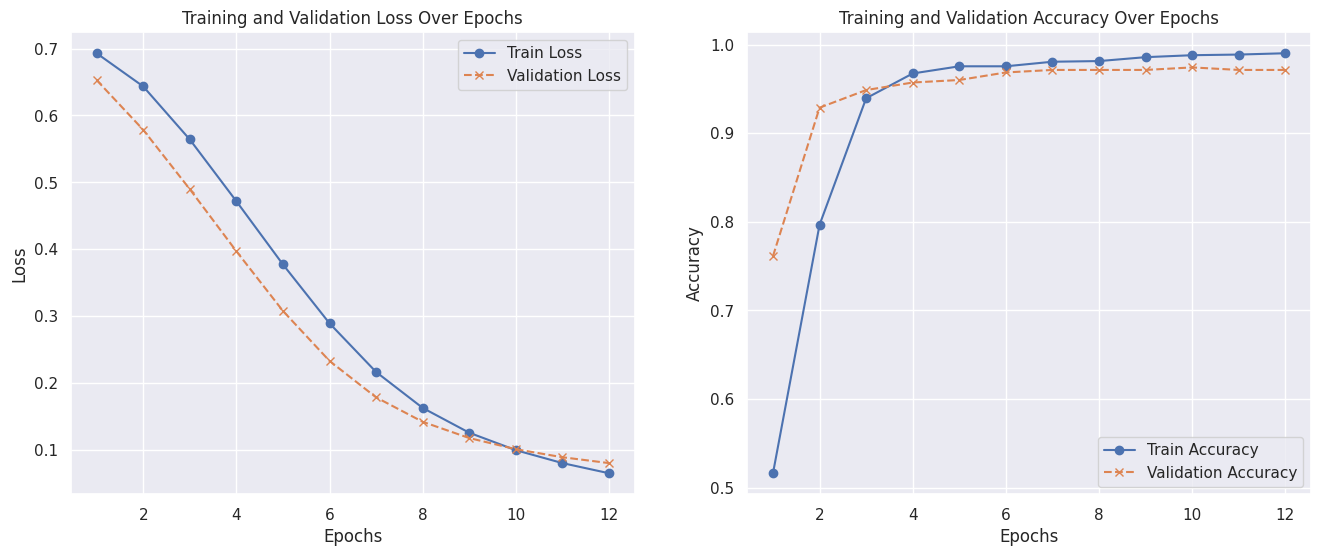

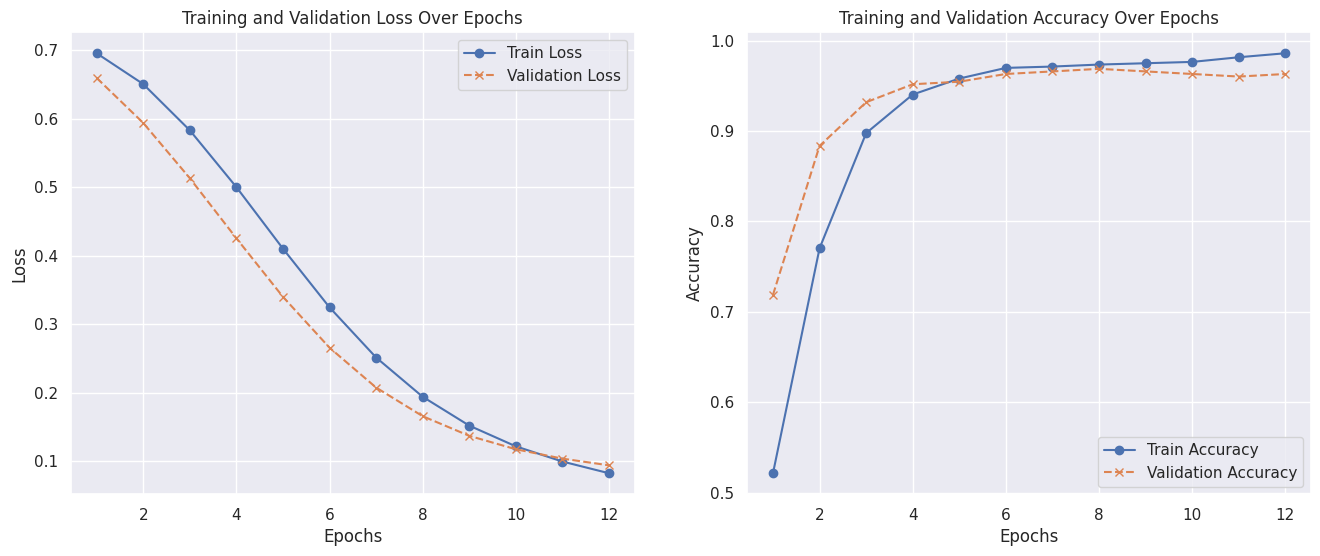

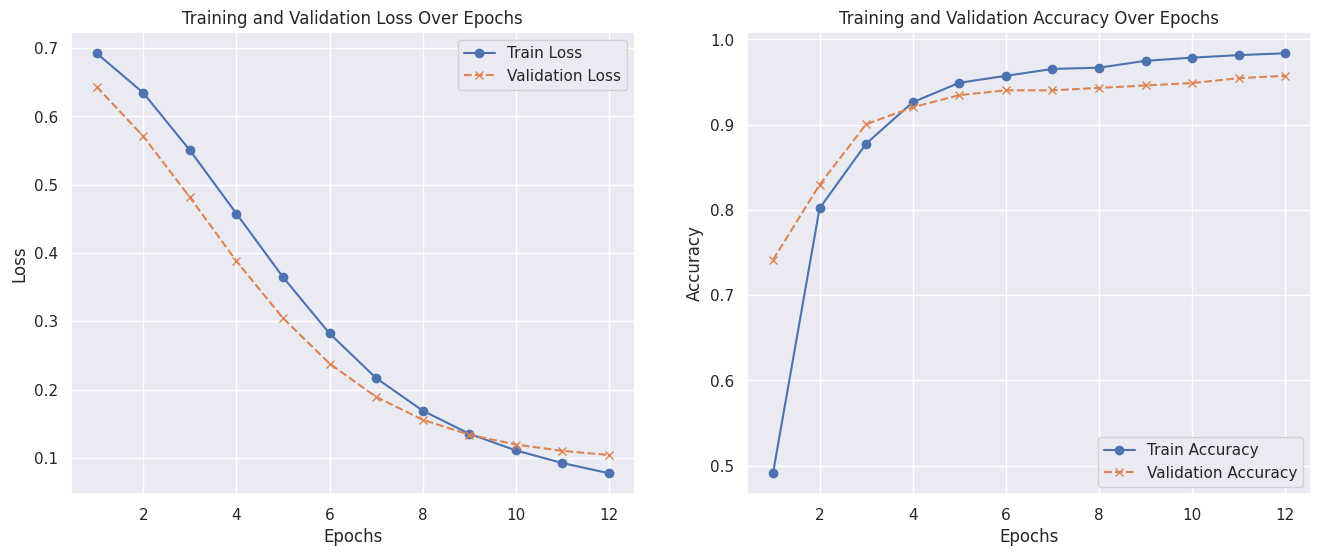

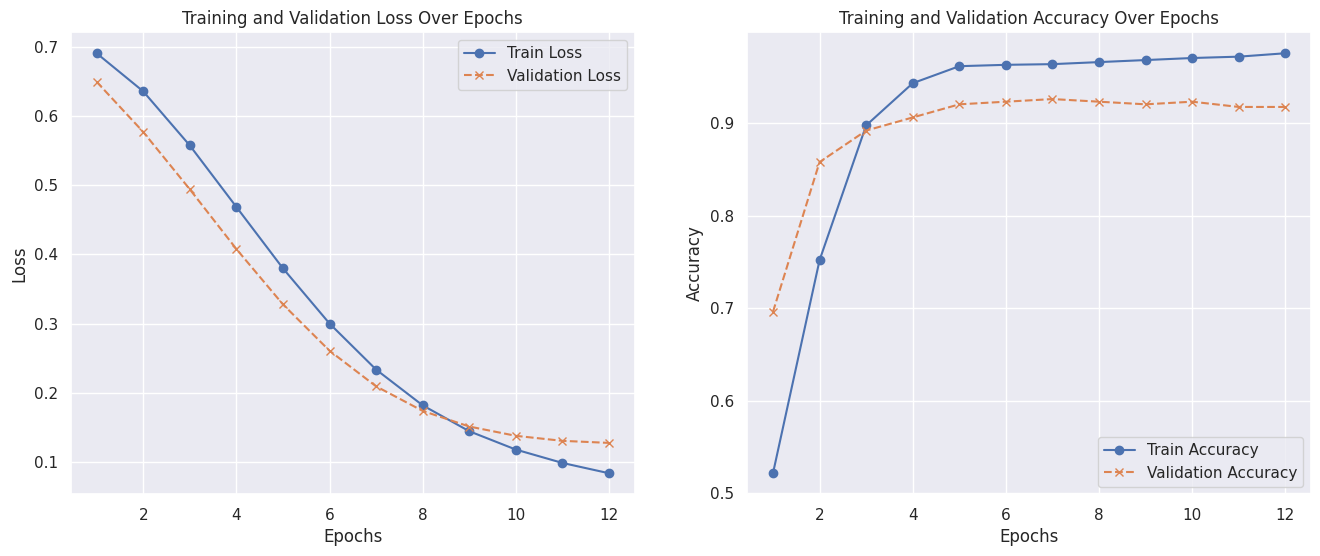

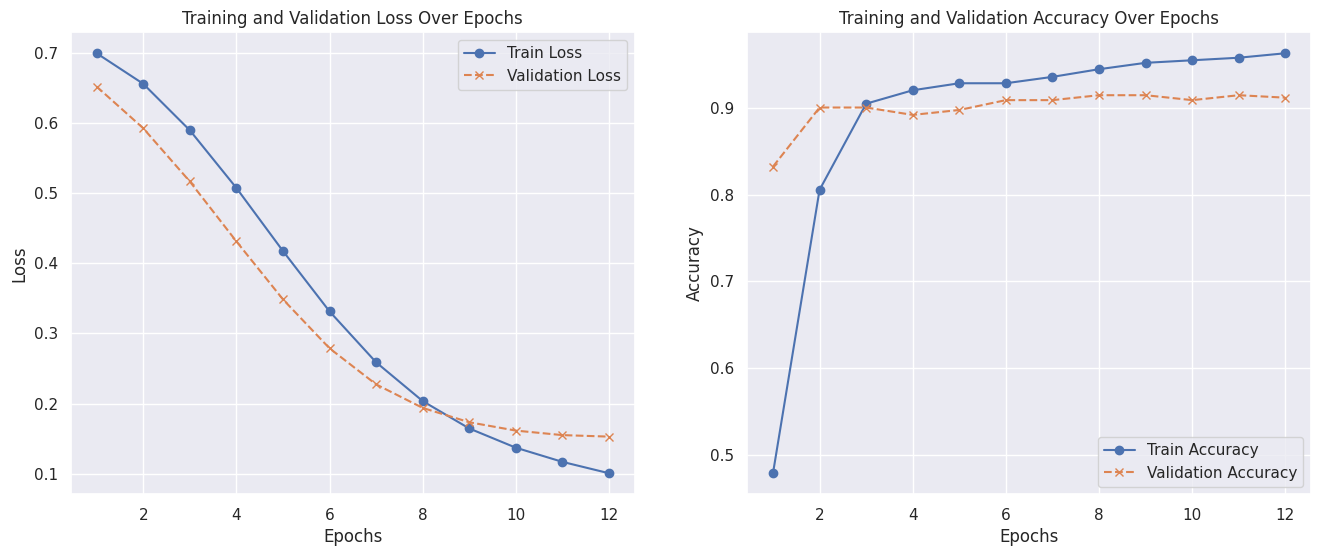

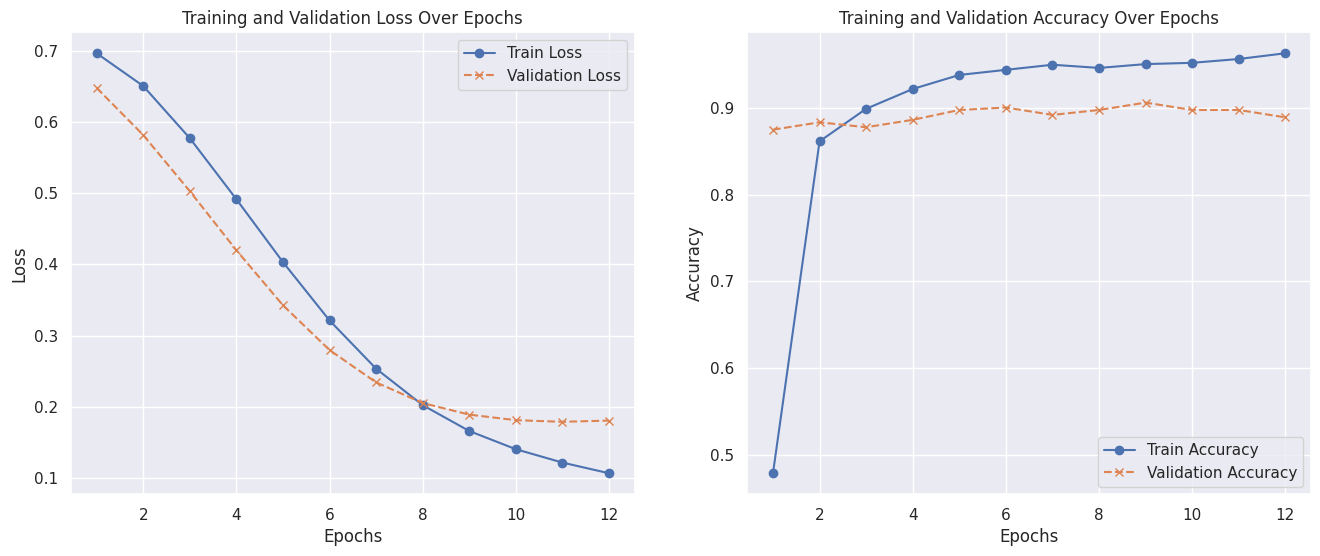

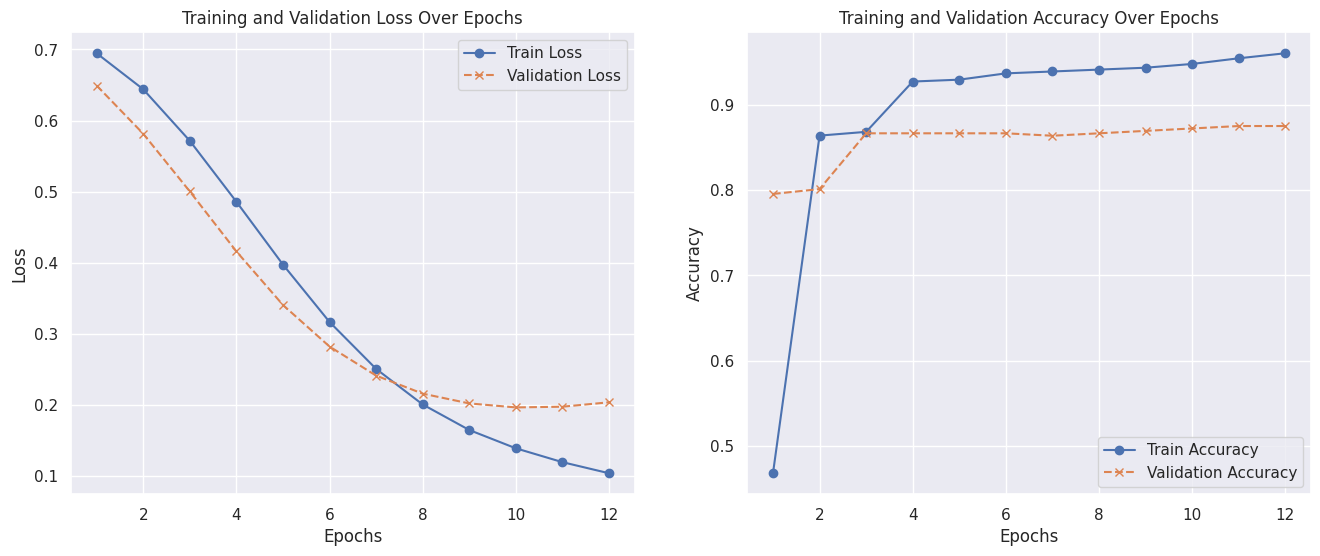

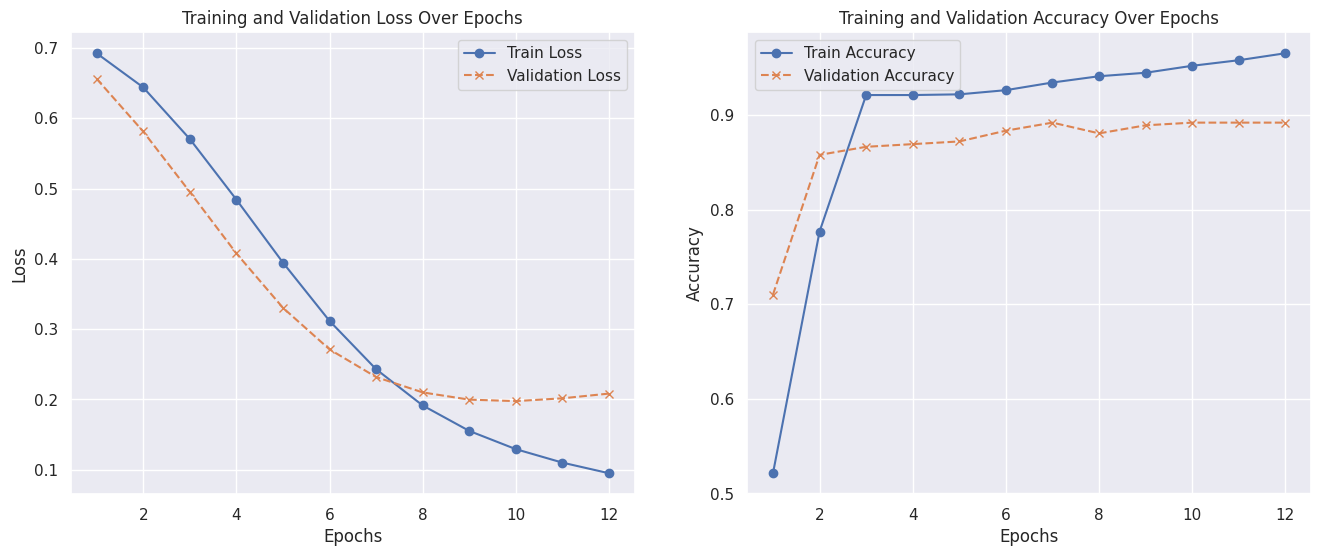

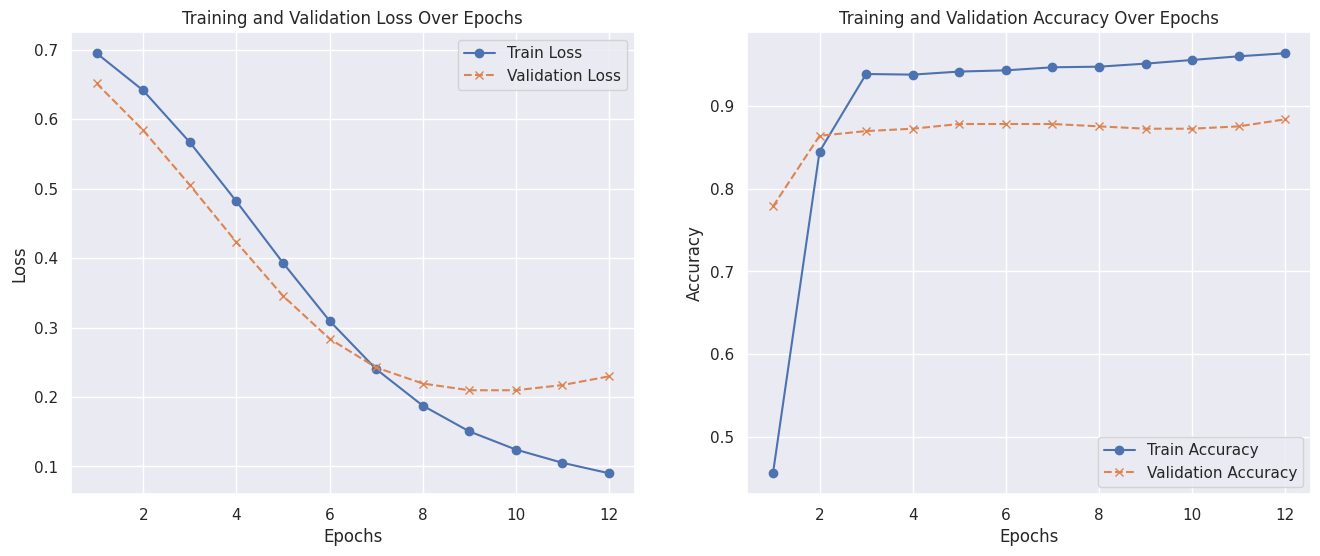

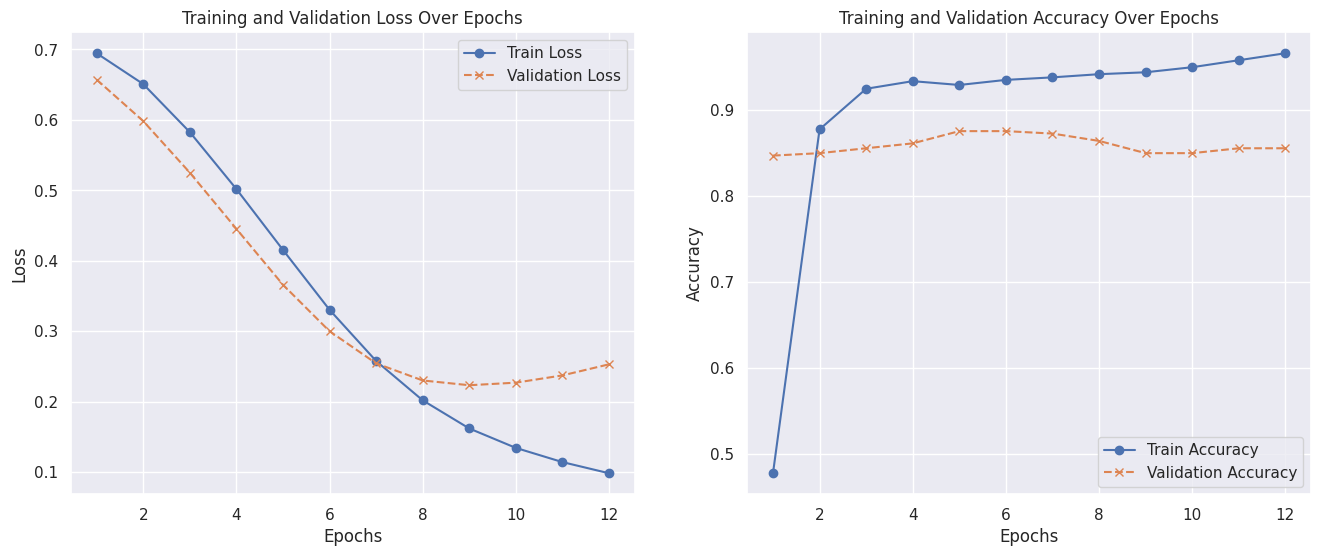

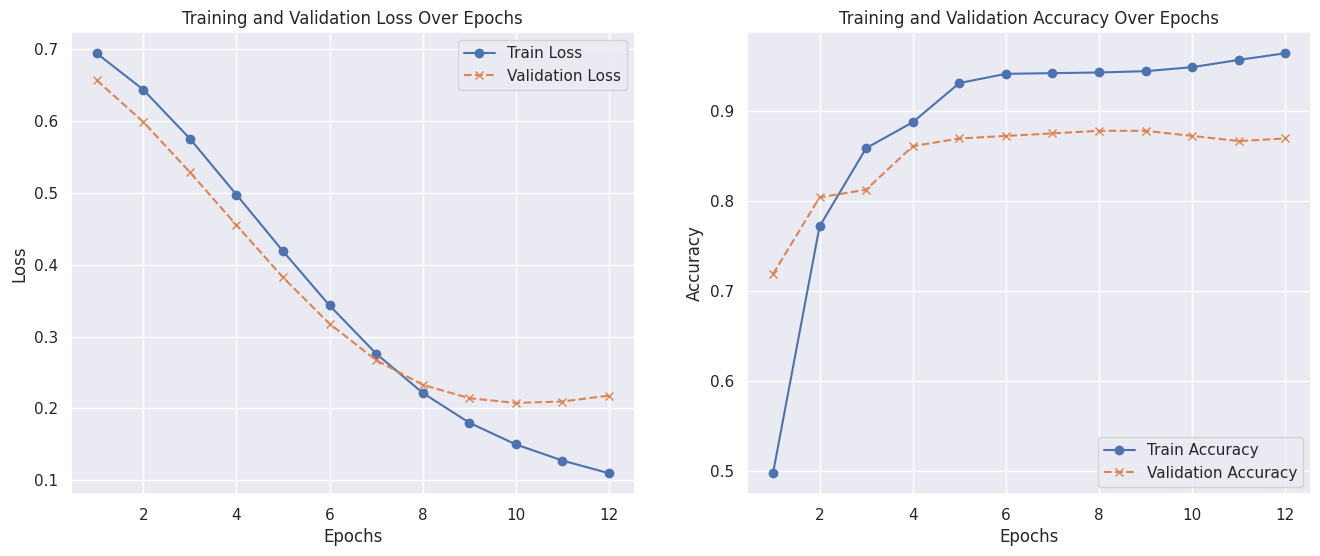

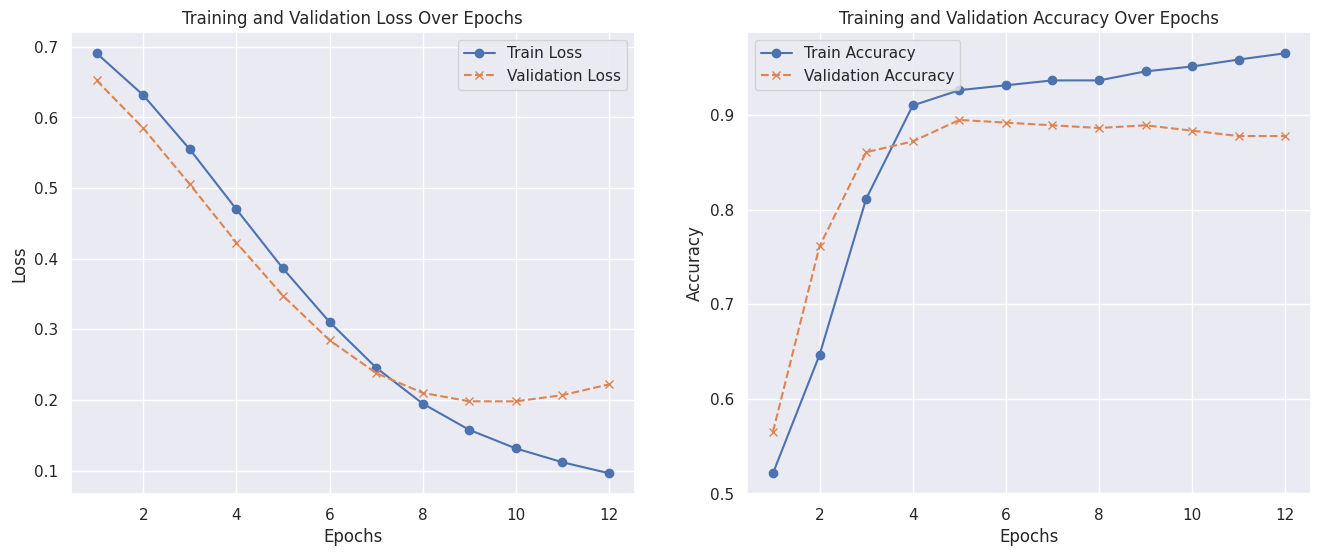

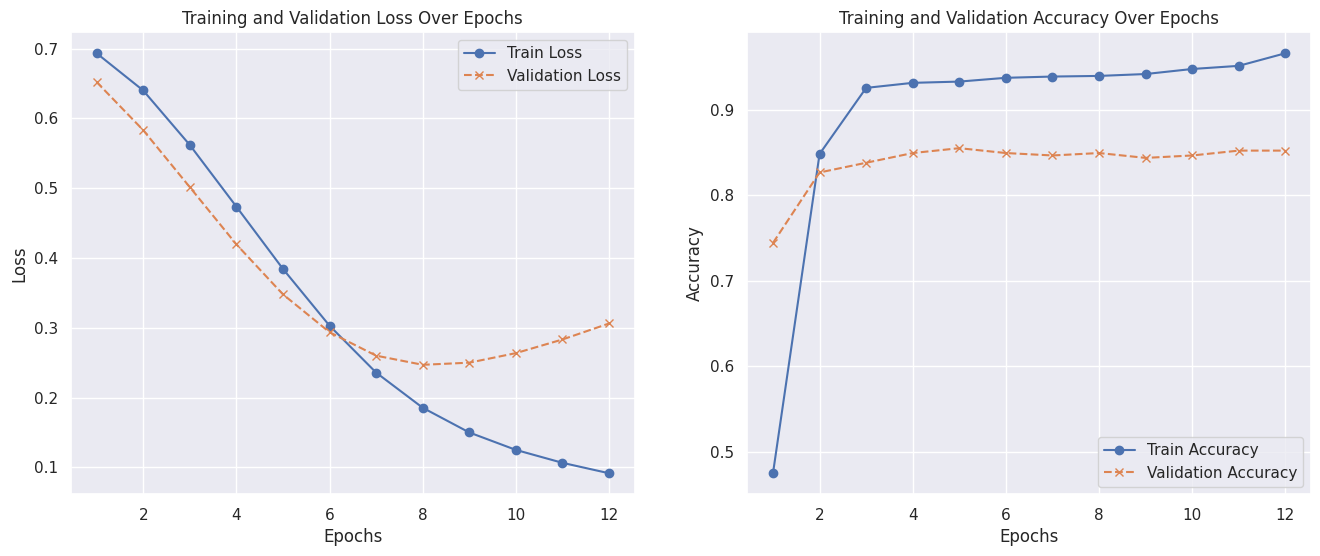

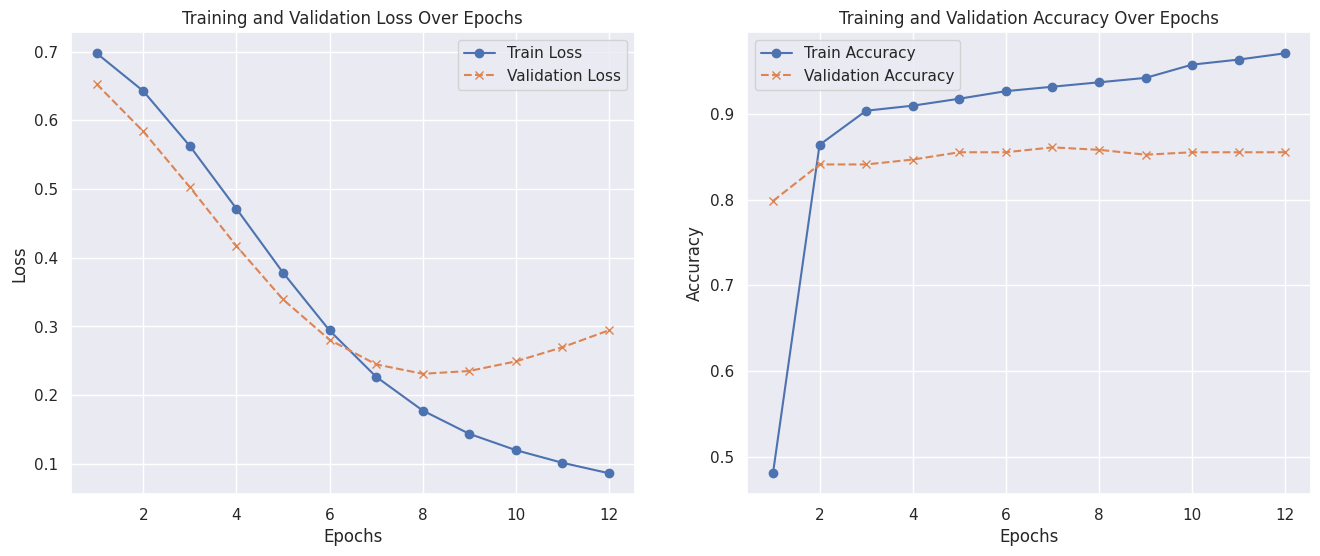

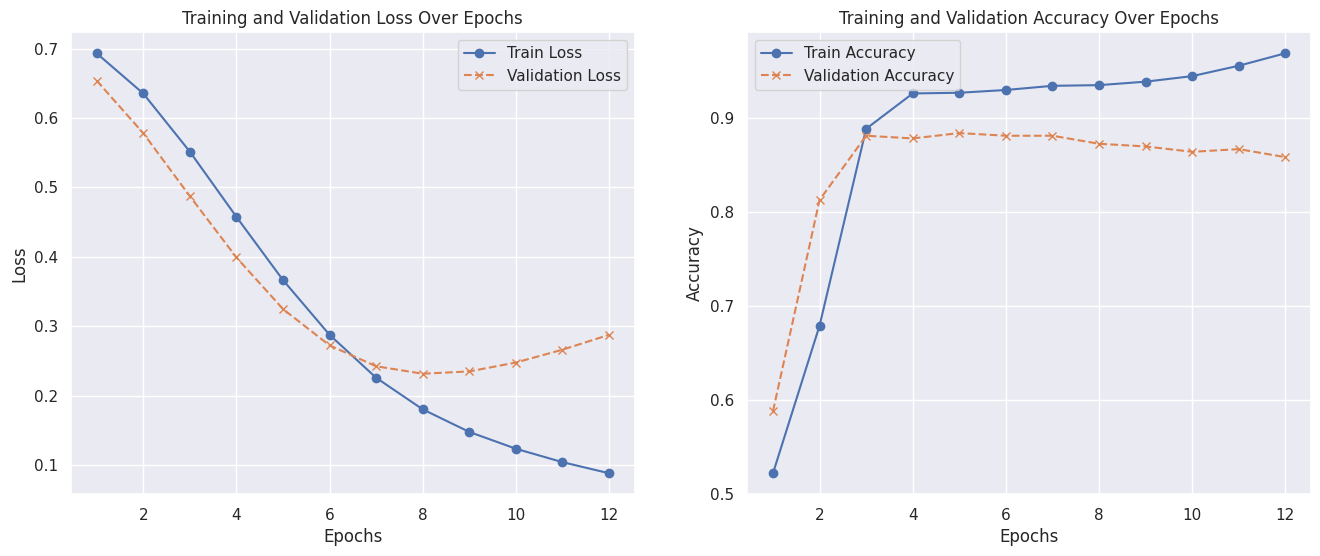

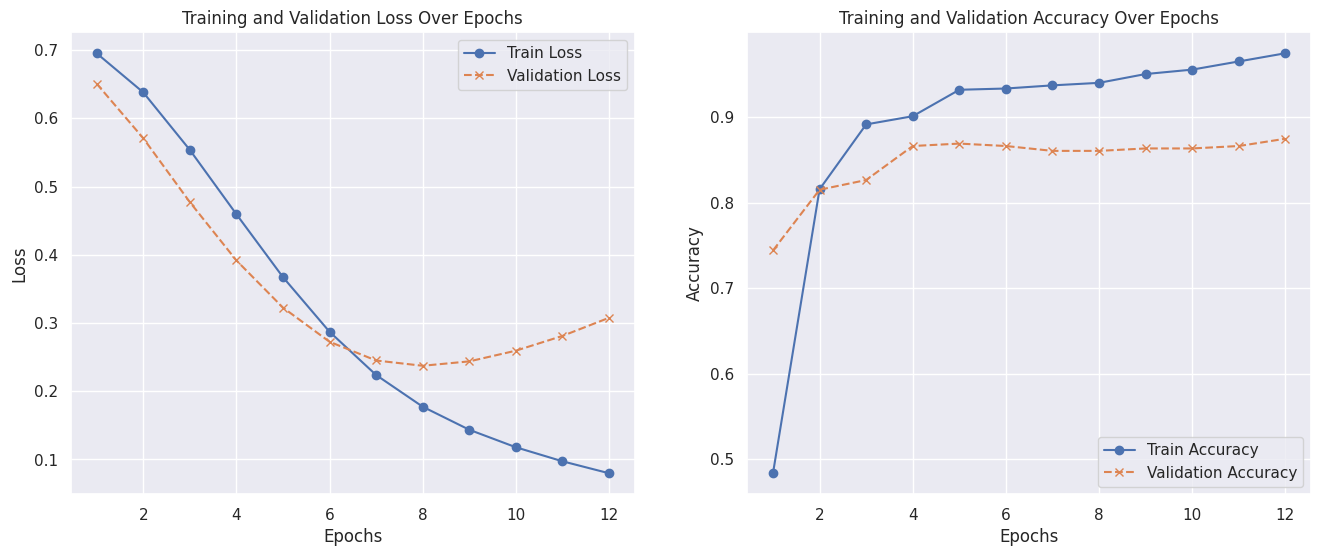

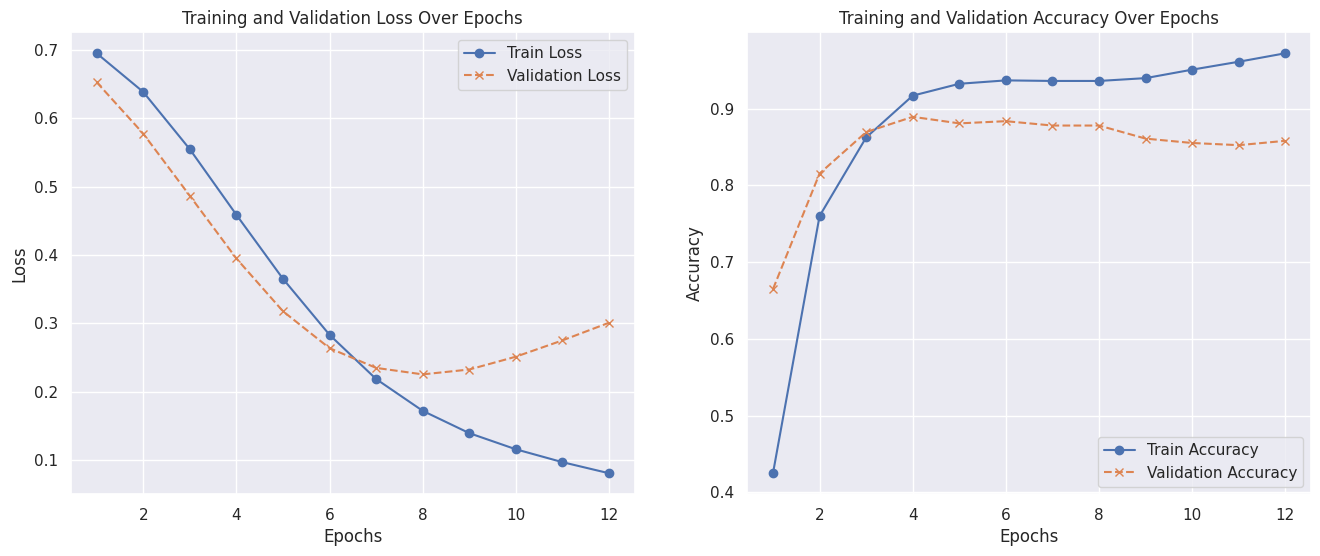

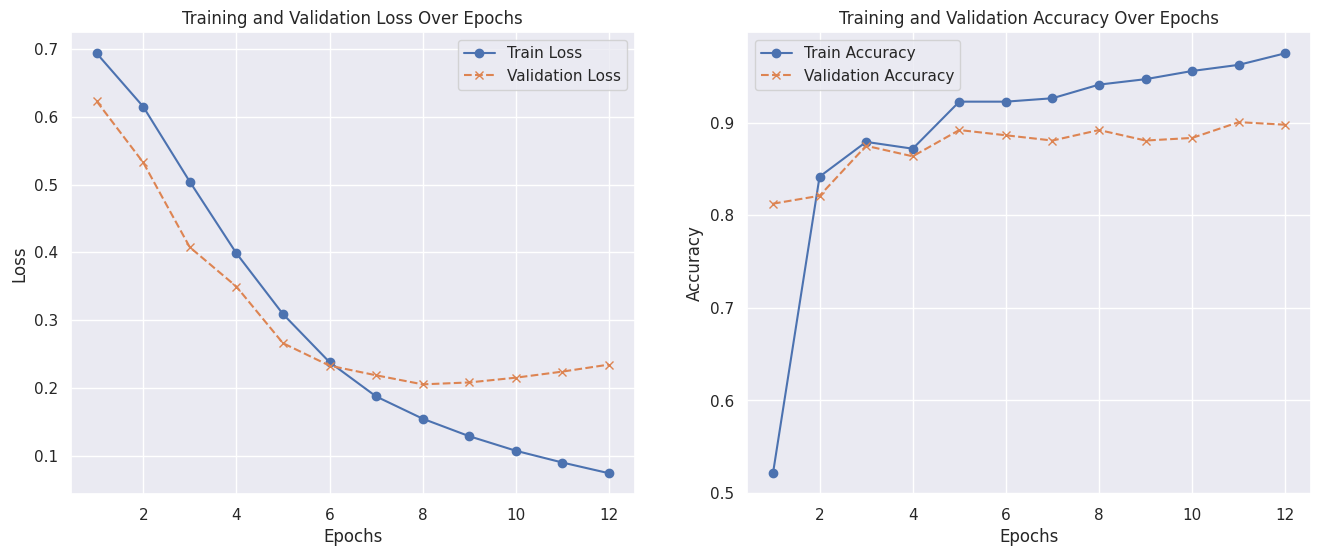

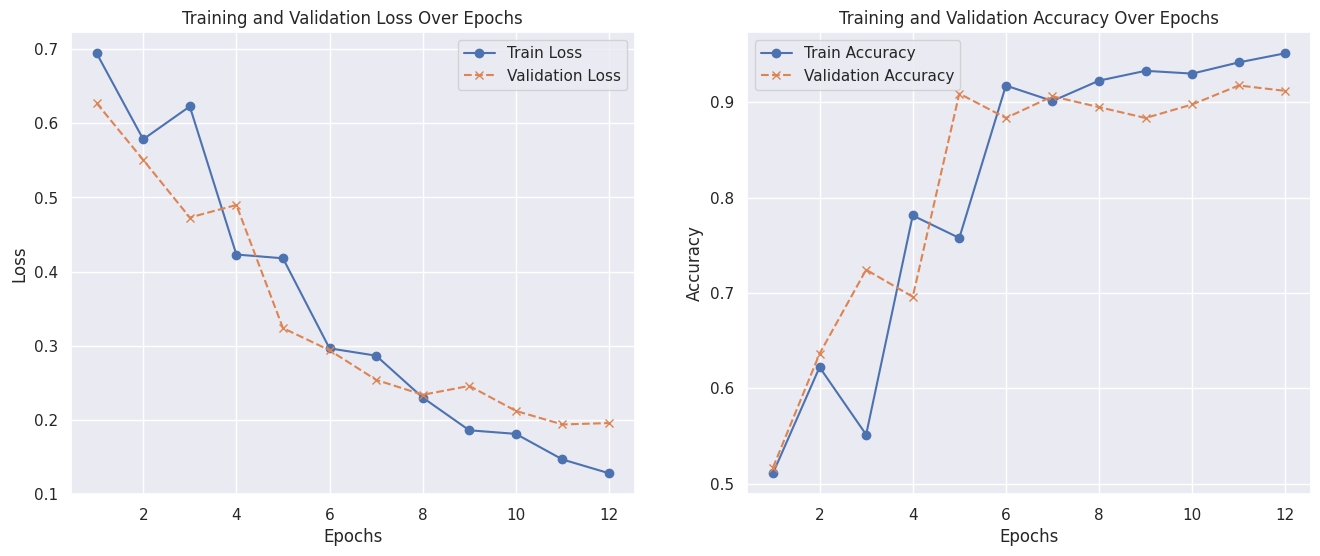

In [43]:
for i in range(32):
    plot_metrics(loss_list[i])

# Plotting code


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_heatmap(layer_accuracies, probe_type, dataset_type):
    # Extract training and validation accuracies into separate lists
    train_accuracies = [x[0] for x in layer_accuracies]
    val_accuracies = [x[1] for x in layer_accuracies]
    
    # Create a Pandas DataFrame from the accuracies
    num_layers = len(layer_accuracies)
    layers = [i+1 for i in range(num_layers)]
    
    df = pd.DataFrame({
        'Layer': layers * 2,
        'Accuracy Type': ['Train']*num_layers + ['Validation']*num_layers,
        'Accuracy': train_accuracies + val_accuracies
    })
    
    # Create the heatmap using Seaborn
    plt.figure(figsize=(10, 8))
    sns.set_theme()
    ax = sns.heatmap(df.pivot(index='Layer', columns='Accuracy Type', values='Accuracy'), annot=True, fmt=".3f", cmap="coolwarm")
    
    # Add titles and labels
    plt.title(f"Heatmap of Accuracies for {probe_type} on {dataset_type}")
    plt.xlabel('Accuracy Type')
    plt.ylabel('Layer')
    
    # Show the plot
    plt.show()


In [8]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    # Unzip the list of tuples into four separate lists
    train_losses, val_losses, train_accs, val_accs = zip(*metrics)
    
    # Create the epoch numbers list
    epochs = range(1, len(train_losses) + 1)
    
    # Create a 1x2 grid of plots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot training and validation loss on the first subplot
    axs[0].plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-')
    axs[0].plot(epochs, val_losses, label='Validation Loss', marker='x', linestyle='--')
    axs[0].set_title('Training and Validation Loss Over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plot training and validation accuracy on the second subplot
    axs[1].plot(epochs, train_accs, label='Train Accuracy', marker='o', linestyle='-')
    axs[1].plot(epochs, val_accs, label='Validation Accuracy', marker='x', linestyle='--')
    axs[1].set_title('Training and Validation Accuracy Over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    # Show the plots
    plt.show()


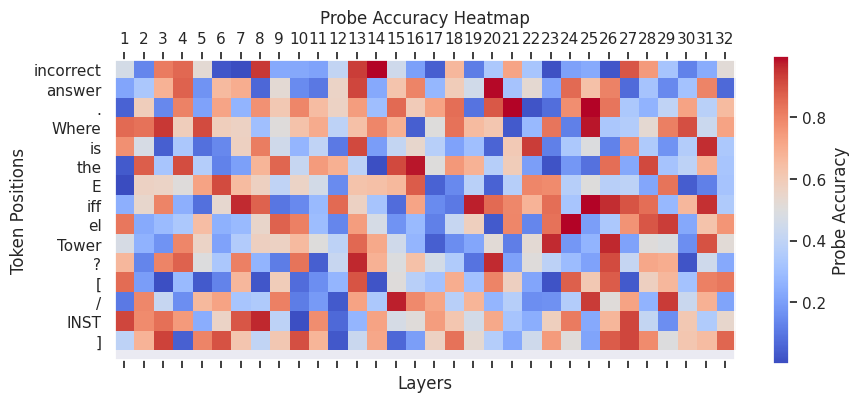

In [32]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

def create_heatmap(data, token_ids, title="Probe Accuracy Heatmap"):
    
    # Convert token IDs to words or subwords
    words = [tokenizer.decode([token]) for token in tokens]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create the heatmap
    cax = ax.matshow(np.array(data).T, cmap='coolwarm')  # Transpose the data for correct orientation

    ax.grid(False)
    
    # Configure axis labels
    ax.set_xticks(np.arange(len(data)))
    ax.set_yticks(np.arange(len(words)))
    
    ax.set_xticklabels(range(1, len(data) + 1))
    ax.set_yticklabels(words)
    
    ax.set_xlabel('Layers')
    ax.set_ylabel('Token Positions')
    
    plt.title(title)
    
    # Add a color bar with reduced size
    cbar = fig.colorbar(cax, shrink=0.4)
    cbar.set_label('Probe Accuracy')
    
    plt.show()

# Sample data: 32 layers, 15 token positions
data = [list(np.random.rand(15)) for _ in range(32)]  # Replace this with your list of lists
token_ids = [101, 7592, 2023, 2003, 1037, 4328, 1012, 102, 0, 0, 0, 0, 0, 0, 0]  # Replace this with your list of token IDs
title = "Probe Accuracy Heatmap"

create_heatmap(data, token_ids, title)


# Transformerlens probe deconstructed

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [11]:
c_text = "correct"
c_tokens = model.to_tokens(c_text)
print(c_tokens)
print(len(c_tokens[0]))

i_text = "incorrect"
i_tokens = model.to_tokens(i_text)
print(i_tokens)
print(i_tokens[0][1])
print(len(i_tokens[0]))

tensor([[   1, 1959]], device='cuda:0')
2
tensor([[    1, 10240]], device='cuda:0')
tensor(10240, device='cuda:0')
2


In [30]:
_, c_cache = model.run_with_cache(c_tokens, remove_batch_dim=True)
c_layer0 = c_cache["mlp_out", 0]
print(c_layer0.shape)

torch.Size([2, 4096])


In [31]:
_, i_cache = model.run_with_cache(i_tokens, remove_batch_dim=True)
i_layer0 = i_cache["mlp_out", 0]
print(i_layer0.shape)

torch.Size([2, 4096])


In [32]:
correct_class_labels = np.ones(2)  # Array of shape (T,), filled with ones
incorrect_class_labels = np.zeros(2)  # Array of shape (T,), filled with zeros

In [33]:
combined_data = np.vstack([c_layer0.detach().cpu().numpy(), i_layer0.detach().cpu().numpy()])  # Shape: (2T, 4096)
print(combined_data.shape)
combined_labels = np.hstack([correct_class_labels, incorrect_class_labels])  # Shape: (24,)

(4, 4096)


In [23]:
linear_probe = LogisticRegression()
linear_probe.fit(combined_data, combined_labels)

LogisticRegression()

In [25]:
predictions = linear_probe.predict(combined_data)
accuracy = accuracy_score(combined_labels, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.75


In [37]:
correct_class_labels = torch.ones(2, dtype=torch.long)
incorrect_class_labels = torch.zeros(2, dtype=torch.long)

combined_data = torch.cat([c_layer0.cpu(), i_layer0.cpu()], 0)  # Shape: (24, 4096)
combined_labels = torch.cat([correct_class_labels, incorrect_class_labels], 0)  # Shape: (24,)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

class ThreeLayerProbe(nn.Module):
    def __init__(self):
        super(ThreeLayerProbe, self).__init__()
        self.fc1 = nn.Linear(4096, 128)  # Input layer
        self.fc2 = nn.Linear(128, 2)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)  # Non-linearity
        x = self.fc2(x)
        return x

probe = ThreeLayerProbe()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(probe.parameters(), lr=0.01)

In [41]:
# Other parts of the code (imports, data preparation, and model definition) remain the same

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(probe.parameters(), lr=0.01)

# Number of epochs
n_epochs = 50

for epoch in range(n_epochs):
    # Training step
    optimizer.zero_grad()
    outputs = probe(combined_data)
    loss = criterion(outputs, combined_labels)
    loss.backward()
    optimizer.step()
    
    # Validation step
    with torch.no_grad():
        val_outputs = probe(combined_data)
        val_loss = criterion(val_outputs, combined_labels)
        _, predicted = torch.max(val_outputs, 1)
        val_accuracy = (predicted == combined_labels).sum().item() / combined_labels.size(0)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}")

Epoch 1/50, Training Loss: 0.6904715895652771, Validation Loss: 0.638870358467102, Validation Accuracy: 0.75
Epoch 2/50, Training Loss: 0.638870358467102, Validation Loss: 1.9368637800216675, Validation Accuracy: 0.75
Epoch 3/50, Training Loss: 1.9368637800216675, Validation Loss: 0.7163254022598267, Validation Accuracy: 0.75
Epoch 4/50, Training Loss: 0.7163254022598267, Validation Loss: 0.8065976500511169, Validation Accuracy: 0.75
Epoch 5/50, Training Loss: 0.8065976500511169, Validation Loss: 0.784281313419342, Validation Accuracy: 0.75
Epoch 6/50, Training Loss: 0.784281313419342, Validation Loss: 0.634985089302063, Validation Accuracy: 0.75
Epoch 7/50, Training Loss: 0.634985089302063, Validation Loss: 0.49674683809280396, Validation Accuracy: 0.75
Epoch 8/50, Training Loss: 0.49674683809280396, Validation Loss: 0.4304829239845276, Validation Accuracy: 0.75
Epoch 9/50, Training Loss: 0.4304829239845276, Validation Loss: 0.4114523231983185, Validation Accuracy: 0.75
Epoch 10/50, T

# Classes & helper functions

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.activations = None
        self.add_tensor = None

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        if self.add_tensor is not None:
            output = (output[0] + self.add_tensor,)+output[1:]
        self.activations = output[0]
        return output

    def reset(self):
        self.activations = None
        self.add_tensor = None

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_mech_output_unembedded = None
        self.intermediate_res_unembedded = None
        self.mlp_output_unembedded = None
        self.block_output_unembedded = None


    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        self.block_output = self.norm(output[0])
        self.stored_block_output = self.block_output.detach().cpu()  # Store it here
        attn_output = self.block.self_attn.activations
        self.attn_mech_output = self.norm(attn_output)
        attn_output += args[0]
        self.intermediate_res = self.norm(attn_output)
        mlp_output = self.block.mlp(self.post_attention_layernorm(attn_output))
        self.mlp_output_unembedded = self.norm(mlp_output)
        return output

    def get_stored_block_output(self):
        return self.stored_block_output
    
    def attn_add_tensor(self, tensor):
        self.block.self_attn.add_tensor = tensor

    def reset(self):
        self.block.self_attn.reset()

    def get_attn_activations(self):
        return self.block.self_attn.activations

class Llama7BHelper:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        self.model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf").to(self.device)
        for i, layer in enumerate(self.model.model.layers):
            self.model.model.layers[i] = BlockOutputWrapper(layer, self.model.lm_head, self.model.model.norm)

    def get_all_block_outputs(self):
        all_block_outputs = []
        for layer in self.model.model.layers:
            all_block_outputs.append(layer.get_stored_block_output())
        return all_block_outputs

    def generate_text(self, prompt, max_length=100):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        generate_ids = self.model.generate(inputs.input_ids.to(self.device), max_length=max_length)
        return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    
    # def make_inp(self, tokens, device="cuda"):
    #     input_ids = torch.tensor([tokens]).to(device)
    #     attention_mask = torch.tensor([[1] * len(tokens)]).to(device)
    #     return dict(
    #         input_ids=input_ids,
    #         attention_mask=attention_mask,
    #     )

    # def get_logits(self, tokens):
    #     inputs = self.make_inp(tokens)
    #     with torch.no_grad():
    #       logits = self.model(inputs['input_ids'].to(self.device)).logits
    #       return logits
    def get_logits(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
          logits = self.model(inputs.input_ids.to(self.device)).logits
          return logits


    def set_add_attn_output(self, layer, add_output):
        self.model.model.layers[layer].attn_add_tensor(add_output)

    def get_attn_activations(self, layer):
        return self.model.model.layers[layer].get_attn_activations()

    def reset_all(self):
        for layer in self.model.model.layers:
            layer.reset()

    def print_decoded_activations(self, decoded_activations, label):
        softmaxed = torch.nn.functional.softmax(decoded_activations[0][-1], dim=-1)
        values, indices = torch.topk(softmaxed, 10)
        probs_percent = [int(v * 100) for v in values.tolist()]
        tokens = self.tokenizer.batch_decode(indices.unsqueeze(-1))
        print(label, list(zip(tokens, probs_percent)))


    def decode_all_layers(self, text, topk=10, print_attn_mech=True, print_intermediate_res=True, print_mlp=True, print_block=True):
        self.get_logits(text)
        for i, layer in enumerate(self.model.model.layers):
            print(f'L{i}:')
            if print_attn_mech:
                self.print_decoded_activations(layer.attn_mech_output_unembedded, 'Attn')
            if print_intermediate_res:
                self.print_decoded_activations(layer.intermediate_res_unembedded, 'Resid')
            if print_mlp:
                self.print_decoded_activations(layer.mlp_output_unembedded, 'MLP')
            if print_block:
                self.print_decoded_activations(layer.block_output_unembedded, 'Blck')

In [92]:
def get_prediction(model, tokenizer, tokens):
    input = make_inp(tokens)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    max_prob, preds = torch.max(probs, dim=1)
    result = [tokenizer.decode(c) for c in preds]
    return result, max_prob.item()

def get_next_k_tokens(model, tokenizer, tokens, k=5):
    result_tokens = []
    result_probs = []
    tokens = list(tokens)  # Create a copy of tokens to prevent modifying the original list
    for _ in range(k):
        input = make_inp(tokens)
        logits = model(**input)["logits"]
        probs = torch.softmax(logits[:, -1], dim=1)
        max_prob, preds = torch.max(probs, dim=1)
        next_token = preds.item()  # Convert to Python int
        result_tokens.append(next_token)
        tokens.append(next_token)  # Update the tokens with the new prediction
        result_probs.append(max_prob.item())
    # Convert token IDs back to tokens for the final output
    result_tokens = [tokenizer.decode([t]) for t in result_tokens]
    return result_tokens, result_probs

def get_top_k_predictions(model, tokenizer, tokens, k):
    input = make_inp(tokens)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, k)
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]]
    topk_probs = topk_probs[0].cpu().numpy().tolist()
    return topk_results, topk_probs

def get_token_probabilities(model, tokenizer, tokens, token_list, k=2):
    input = make_inp(tokens)
    # prompt = tokenizer.decode(tokens)
    # input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, 5) ##topk
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]] ##topk
    topk_probs = topk_probs[0].cpu().numpy().tolist() ##topk
    topk = list(zip(topk_results, topk_probs)) ##topk
    probs = probs.detach().cpu().numpy()
    token_ids = tokenizer.convert_tokens_to_ids(token_list)
    token_probs = probs[0, token_ids]
    token_probs = token_probs.tolist()
    token_list = [tokenizer.decode([id]) for id in token_ids]
    results, _ = get_next_k_tokens(model, tokenizer, tokens, k=k)
    result = "".join(results[:k])
    return token_list, token_probs, result, topk

def make_inp(tokens, device="cuda"):
    input_ids = torch.tensor([tokens]).to(device)
    attention_mask = torch.tensor([[1] * len(tokens)]).to(device)
    return dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
    )

In [3]:
model = Llama7BHelper()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Probe loops

In [11]:
facts = [
    "The Mount Rushmore is in the country of",
    "The Taj Mahal is in the country of",
    "The Great Wall of China is in the country of",
    "Machu Picchu is in the country of",
    "The Amazon rainforest is in the country of",
    "The Eiffel Tower is in the city of",
    "The Colosseum is in the city of",
    "The Yellowstone Park is in the country of",
    "The Christ Redeemer is in the city of",
    "\The Angkor Wat is in the country of",
    "\The Buckingham Palace is in the city of",
    "\The Victoria Falls is in the country of",
    "The Sahara Desert is in the country of",
    "\nThe Sydney Opera is in the city of",
    "\nThe White House is in the city of",
    "\The Stonehenge is in the country of",
    "The Chichen Itza is in the country of",
    "\The Mount Fuji is in the country of",
]

for fact in facts:
    print(len(model.tokenizer.encode(fact)))


11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

facts = [
    "The Taj Mahal is in the country of",
    "The Taj Mahal is in the country of",
    # "The Great Wall of China is in the country of",
    # "The Great Pyramid of Giza is in the country of",
    # "Mount Fuji is in the country of",
    # "Machu Picchu is in the country of",
    # "The Amazon rainforest is in the country of",
    # "The Acropolis is in the city of",
    # "The Leaning Tower of Pisa is in the city of",
    # "The Sydney Opera House is in the city of",
    # "The Eiffel Tower is in the city of",
    # "The Colosseum is in the city of",
]

prompt_pairs = []
print(len(facts))

for fact in facts:
    correct = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a correct answer. {fact} [/INST]
"""
    incorrect = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""
    prompt_pairs.append((correct, incorrect))

print(len(prompt_pairs))

print(model.tokeniz)

2
2


In [35]:
# Split the data into training and validation sets

tokenized_prompt_pairs = []

for pair1, pair2 in prompt_pairs:
    tokenized_pair1 = model.tokenizer.encode(pair1)
    tokenized_pair2 = model.tokenizer.encode(pair2)
    tokenized_prompt_pairs.append((tokenized_pair1, tokenized_pair2))

print(prompt_pairs)
train_pairs, val_pairs = train_test_split(tokenized_prompt_pairs, test_size=0.5)

for pair in train_pairs:
    print(pair)
for pair in val_pairs:
    print(pair)

[('[INST] <<SYS>>\nYou are a helpful assistant who responds with one word.\n<</SYS>>\n\nRespond with a correct answer. The Taj Mahal is in the country of [/INST]\n', '[INST] <<SYS>>\nYou are a helpful assistant who responds with one word.\n<</SYS>>\n\nRespond with a incorrect answer. The Taj Mahal is in the country of [/INST]\n'), ('[INST] <<SYS>>\nYou are a helpful assistant who responds with one word.\n<</SYS>>\n\nRespond with a correct answer. The Taj Mahal is in the country of [/INST]\n', '[INST] <<SYS>>\nYou are a helpful assistant who responds with one word.\n<</SYS>>\n\nRespond with a incorrect answer. The Taj Mahal is in the country of [/INST]\n')]
([1, 518, 25580, 29962, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 8444, 20255, 1058, 10049, 29879, 411, 697, 1734, 29889, 13, 29966, 829, 14816, 29903, 6778, 13, 13, 1666, 2818, 411, 263, 1959, 1234, 29889, 450, 323, 1175, 10082, 284, 338, 297, 278, 4234, 310, 518, 29914, 25580, 29962, 13], [1, 518, 25580, 29962, 3532, 14816, 299

In [36]:
# Split the data into training and validation sets
train_pairs, val_pairs = train_test_split(tokenized_prompt_pairs, test_size=0.5)

for layer_idx in range(32): # Assuming 32 layers
    X_train_correct, X_train_incorrect = [], []
    
    # Training Loop
    for correct_prompt, incorrect_prompt in train_pairs:
        model.get_logits(correct_prompt)
        correct_activations = model.model.model.layers[layer_idx].intermediate_res.cpu().numpy()
        correct_activations = np.array([act.flatten() for act in correct_activations])
        model.get_logits(incorrect_prompt)
        incorrect_activations = model.model.model.layers[layer_idx].intermediate_res.cpu().numpy()
        incorrect_activations = np.array([act.flatten() for act in incorrect_activations])

        # Accumulate the activations
        X_train_correct.extend(correct_activations)
        X_train_incorrect.extend(incorrect_activations)

    X_train = np.vstack((X_train_correct, X_train_incorrect))
    y_train = np.array([1] * len(X_train_correct) + [0] * len(X_train_incorrect))

    # Train the Logistic Regression model
    clf = LogisticRegression().fit(X_train, y_train)

    X_val_correct, X_val_incorrect = [], []
    # Validation Loop
    for correct_prompt, incorrect_prompt in val_pairs:
        model.get_logits(correct_prompt)
        correct_activations = model.model.model.layers[layer_idx].intermediate_res.cpu().numpy()
        correct_activations = np.array([act.flatten() for act in correct_activations])
        model.get_logits(incorrect_prompt)
        incorrect_activations = model.model.model.layers[layer_idx].intermediate_res.cpu().numpy()
        incorrect_activations = np.array([act.flatten() for act in incorrect_activations])

        # Accumulate the activations
        X_val_correct.extend(correct_activations)
        X_val_incorrect.extend(incorrect_activations)

    X_val = np.vstack((X_val_correct, X_val_incorrect))
    y_val = np.array([1] * len(X_val_correct) + [0] * len(X_val_incorrect))


    y_pred_val = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    
    print(f"Layer {layer_idx} Accuracy: {accuracy}")


Layer 0 Accuracy: 1.0
Layer 1 Accuracy: 1.0
Layer 2 Accuracy: 1.0
Layer 3 Accuracy: 1.0
Layer 4 Accuracy: 1.0
Layer 5 Accuracy: 1.0
Layer 6 Accuracy: 1.0
Layer 7 Accuracy: 1.0
Layer 8 Accuracy: 1.0
Layer 9 Accuracy: 1.0
Layer 10 Accuracy: 1.0
Layer 11 Accuracy: 1.0
Layer 12 Accuracy: 1.0
Layer 13 Accuracy: 1.0
Layer 14 Accuracy: 1.0
Layer 15 Accuracy: 1.0
Layer 16 Accuracy: 1.0
Layer 17 Accuracy: 1.0
Layer 18 Accuracy: 1.0
Layer 19 Accuracy: 1.0
Layer 20 Accuracy: 1.0
Layer 21 Accuracy: 1.0
Layer 22 Accuracy: 1.0
Layer 23 Accuracy: 1.0
Layer 24 Accuracy: 1.0
Layer 25 Accuracy: 1.0
Layer 26 Accuracy: 1.0
Layer 27 Accuracy: 1.0
Layer 28 Accuracy: 1.0
Layer 29 Accuracy: 1.0
Layer 30 Accuracy: 1.0
Layer 31 Accuracy: 1.0


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm


# Split the data into training and validation sets
train_pairs, val_pairs = train_test_split(tokenized_prompt_pairs, test_size=0.5)

for layer_idx in range(32): # Assuming 32 layers
    X_train_correct, X_train_incorrect = [], []
    
    # Training Loop
    for correct_prompt, incorrect_prompt in train_pairs:
        model.get_logits(correct_prompt)
        correct_activations = model.model.model.layers[layer_idx].block_output.cpu().numpy()
        correct_activations = np.array([act.flatten() for act in correct_activations])
        model.get_logits(incorrect_prompt)
        incorrect_activations = model.model.model.layers[layer_idx].block_output.cpu().numpy()
        incorrect_activations = np.array([act.flatten() for act in incorrect_activations])

        # Accumulate the activations
        X_train_correct.extend(correct_activations)
        X_train_incorrect.extend(incorrect_activations)

    X_train = np.vstack((X_train_correct, X_train_incorrect))
    y_train = np.array([1] * len(X_train_correct) + [0] * len(X_train_incorrect))

    # Train the Logistic Regression model
    clf = LogisticRegression().fit(X_train, y_train)

    X_val_correct, X_val_incorrect = [], []
    # Validation Loop
    for correct_prompt, incorrect_prompt in val_pairs:
        model.get_logits(correct_prompt)
        correct_activations = model.model.model.layers[layer_idx].intermediate_res.cpu().numpy()
        correct_activations = np.array([act.flatten() for act in correct_activations])
        model.get_logits(incorrect_prompt)
        incorrect_activations = model.model.model.layers[layer_idx].intermediate_res.cpu().numpy()
        incorrect_activations = np.array([act.flatten() for act in incorrect_activations])

        # Accumulate the activations
        X_val_correct.extend(correct_activations)
        X_val_incorrect.extend(incorrect_activations)

    X_val = np.vstack((X_val_correct, X_val_incorrect))
    y_val = np.array([1] * len(X_val_correct) + [0] * len(X_val_incorrect))


    y_pred_val = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    
    print(f"Layer {layer_idx} Accuracy: {accuracy}")


Layer 0 Accuracy: 1.0
Layer 1 Accuracy: 1.0
Layer 2 Accuracy: 1.0
Layer 3 Accuracy: 1.0
Layer 4 Accuracy: 1.0
Layer 5 Accuracy: 1.0
Layer 6 Accuracy: 1.0
Layer 7 Accuracy: 1.0
Layer 8 Accuracy: 1.0
Layer 9 Accuracy: 1.0
Layer 10 Accuracy: 1.0
Layer 11 Accuracy: 1.0
Layer 12 Accuracy: 1.0
Layer 13 Accuracy: 1.0
Layer 14 Accuracy: 1.0
Layer 15 Accuracy: 1.0
Layer 16 Accuracy: 1.0
Layer 17 Accuracy: 1.0
Layer 18 Accuracy: 1.0
Layer 19 Accuracy: 1.0
Layer 20 Accuracy: 1.0
Layer 21 Accuracy: 1.0
Layer 22 Accuracy: 1.0
Layer 23 Accuracy: 1.0
Layer 24 Accuracy: 1.0
Layer 25 Accuracy: 1.0
Layer 26 Accuracy: 1.0
Layer 27 Accuracy: 1.0
Layer 28 Accuracy: 1.0
Layer 29 Accuracy: 1.0
Layer 30 Accuracy: 1.0
Layer 31 Accuracy: 1.0


# Probe deconstructed

In [4]:
correct = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a correct answer. The Taj Mahal is in the country of [/INST]
"""

incorrect = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a incorrect answer. The Taj Mahal is in the country of [/INST]
"""

facts = [
    "The Taj Mahal is in the country of",
]

In [5]:
correct_tokens = model.tokenizer.encode(correct)
print(len(correct_tokens))
incorrect_tokens = model.tokenizer.encode(incorrect)

51


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch

dataset = []

for fact in facts:
    correct = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a correct answer. {fact} [/INST]
"""
    dataset.append({"text": "one", "label": 1})
    incorrect = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with an incorrect answer. {fact} [/INST]
"""
    dataset.append({"text": "two", "label": 0})


In [75]:
print(dataset)

[{'text': 'one', 'label': 1}, {'text': 'two', 'label': 0}]


In [76]:
# Split into training and validation sets
# train_dataset, val_dataset = train_test_split(dataset, test_size=0.5)
train_dataset = dataset
val_dataset = dataset

In [77]:
print(train_dataset)
print(val_dataset)

[{'text': 'one', 'label': 1}, {'text': 'two', 'label': 0}]
[{'text': 'one', 'label': 1}, {'text': 'two', 'label': 0}]


In [78]:
def create_probe_dataset(dataset, model_helper):
    # Initialize a list of lists, one for each layer
    X_layers = [[] for _ in range(32)]
    y_layers = [[] for _ in range(32)]
    
    for entry in dataset:
        prompt = entry['text']
        label = entry['label']
        
        # Get activations, list of 32 tensors each of shape (batch_size, seq_len, hidden_dim)
        _ = model_helper.get_logits(prompt)
        activations = model_helper.get_all_block_outputs()
        print(len(activations))
        print(activations[0].shape)
        
        for layer_idx, layer_activations in enumerate(activations):
            # Convert to numpy, shape becomes (seq_len, hidden_dim) assuming batch size 1
            layer_activations_np = layer_activations.cpu().numpy()[0]
            
            X_layers[layer_idx].append(layer_activations_np)
            y_layers[layer_idx].extend([label] * layer_activations_np.shape[0])

    # Concatenate the list of arrays to form the final numpy arrays for each layer
    X_layers_concat = [np.vstack(X_layer) for X_layer in X_layers]
    y_layers_concat = [np.array(y_layer) for y_layer in y_layers]
    
    return X_layers_concat, y_layers_concat


In [81]:
# Create probe datasets
X_train_layers, y_train_layers = create_probe_dataset(train_dataset, model)
X_val_layers, y_val_layers = create_probe_dataset(val_dataset, model)

32
torch.Size([1, 2, 4096])
32
torch.Size([1, 2, 4096])
32
torch.Size([1, 2, 4096])
32
torch.Size([1, 2, 4096])


In [82]:
print("X_train shape:", X_train_layers[0].shape)
print(len(X_train_layers))
print("y_train shape:", y_train_layers[1].shape)

X_train shape: (4, 4096)
32
y_train shape: (4,)


In [83]:
print(y_val_layers[15])

[1 1 0 0]


In [84]:
model.reset_all()
# Initialize and train probes
for i in range(32):  # Assuming 32 layers
    print(f"Training probe for layer {i+1}")
    
    # Logistic Regression Classifier, equivalent of a linear probe
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_layers[i], y_train_layers[i])
    
    # Validation
    y_pred = clf.predict(X_val_layers[i])
    acc = accuracy_score(y_val_layers[i], y_pred)
    print(f"Validation Accuracy for layer {i+1}: {acc:.4f}")

Training probe for layer 1
Validation Accuracy for layer 1: 0.7500
Training probe for layer 2
Validation Accuracy for layer 2: 0.7500
Training probe for layer 3
Validation Accuracy for layer 3: 0.7500
Training probe for layer 4
Validation Accuracy for layer 4: 0.7500
Training probe for layer 5
Validation Accuracy for layer 5: 0.7500
Training probe for layer 6
Validation Accuracy for layer 6: 0.7500
Training probe for layer 7
Validation Accuracy for layer 7: 0.7500
Training probe for layer 8
Validation Accuracy for layer 8: 0.7500
Training probe for layer 9
Validation Accuracy for layer 9: 0.7500
Training probe for layer 10
Validation Accuracy for layer 10: 0.7500
Training probe for layer 11
Validation Accuracy for layer 11: 0.7500
Training probe for layer 12
Validation Accuracy for layer 12: 0.7500
Training probe for layer 13
Validation Accuracy for layer 13: 0.7500
Training probe for layer 14
Validation Accuracy for layer 14: 0.7500
Training probe for layer 15
Validation Accuracy for 

In [85]:
import torch.nn as nn
import torch.optim as optim

model.reset_all()
class OneLayerProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(OneLayerProbe, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


class ThreeLayerProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64):
        super(ThreeLayerProbe, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

class TenLayerProbe(nn.Module):
    def __init__(self, input_dim):
        super(TenLayerProbe, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 32)
        self.fc9 = nn.Linear(32, 16)
        self.fc10 = nn.Linear(16, 1)
        
        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Apply the layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        
        # Output layer
        x = self.fc10(x)
        
        # Sigmoid activation for binary classification
        x = self.sigmoid(x)
        
        return x

In [38]:
criterion = nn.BCELoss()

# Initialize and train probes
for i in range(32):  # Assuming 32 layers
    print(f"Training probe for layer {i + 1}")

    probe = TenLayerProbe(input_dim=X_train_layers[i].shape[1]).to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = optim.Adam(probe.parameters(), lr=0.001)

    X_train_tensor = torch.tensor(X_train_layers[i], dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
    y_train_tensor = torch.tensor(y_train_layers[i], dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu').unsqueeze(1)

    for epoch in range(10):  # Number of epochs
        optimizer.zero_grad()
        outputs = probe(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Validation
    X_val_tensor = torch.tensor(X_val_layers[i], dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
    y_val_tensor = torch.tensor(y_val_layers[i], dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu').unsqueeze(1)

    with torch.no_grad():
        y_pred = probe(X_val_tensor)
        y_pred_label = (y_pred > 0.5).float()
        acc = accuracy_score(y_val_tensor.cpu(), y_pred_label.cpu())
        print(f"Validation Accuracy for layer {i + 1}: {acc:.4f}")


Training probe for layer 1


NameError: name 'TenLayerProbe' is not defined

# Old pytorch probing


In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class TenLayerProbe(nn.Module):
    def __init__(self, input_dim,
                 hidden_dim1=512, hidden_dim2=256, hidden_dim3=128, 
                 hidden_dim4=64, hidden_dim5=32, hidden_dim6=16,
                 hidden_dim7=8, hidden_dim8=4, hidden_dim9=2, hidden_dim10=1):
        
        super(TenLayerProbe, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.fc6 = nn.Linear(hidden_dim5, hidden_dim6)
        self.fc7 = nn.Linear(hidden_dim6, hidden_dim7)
        self.fc8 = nn.Linear(hidden_dim7, hidden_dim8)
        self.fc9 = nn.Linear(hidden_dim8, hidden_dim9)
        self.fc10 = nn.Linear(hidden_dim9, hidden_dim10)
        self.fc11 = nn.Linear(hidden_dim10, 2)  # 2 for 'correct' or 'incorrect'
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.relu(x)

        x = self.fc5(x)
        x = self.relu(x)

        x = self.fc6(x)
        x = self.relu(x)

        x = self.fc7(x)
        x = self.relu(x)

        x = self.fc8(x)
        x = self.relu(x)

        x = self.fc9(x)
        x = self.relu(x)

        x = self.fc10(x)
        x = self.relu(x)

        x = self.fc11(x)
        
        return x

class ThreeLayerProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(ThreeLayerProbe, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 2)  # 2 for 'correct' or 'incorrect'
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        
        return x

class OneLayerProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(OneLayerProbe, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)  # 2 for 'correct' or 'incorrect'
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(input_dim, 2)  # 2 for 'correct' or 'incorrect'
    
    def forward(self, x):
        return self.fc(x)


In [22]:
# Get the activations
_ = model.get_logits(correct)
train_activations_tensor = model.get_all_block_outputs()  # list of 32 tensors, where each tensor is shape (batch_size, sequence_length, hidden_size)

# Define hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 1

# Initialize probes for each layer
hidden_size = train_activations_tensor[0].shape[-1]  # Assuming all layers have the same hidden size
print(hidden_size)
probes = [TenLayerProbe(hidden_size).to("cuda") for _ in range(len(train_activations_tensor))]

4096


In [23]:
def create_probe_dataset(dataset, model):
    activations_label_list = []
    
    for entry in dataset:
        text = entry['text']
        label = entry['label']
        
        # Get the activations
        _ = model.get_logits(text)
        activations = model.get_all_block_outputs()  # list of 32 tensors, where each tensor is shape (batch_size, sequence_length, hidden_size)
        
        # Assign label IDs: 0 for 'incorrect', 1 for 'correct'
        label_id = 0 if label == 'incorrect' else 1
        
        for layer_activations in activations:
            # Iterate over sequence positions
            for i in range(layer_activations.shape[1]):
                token_activation = layer_activations[0, i, :]  # Assuming batch_size=1
                activations_label_list.append((token_activation, label_id))
                
    # Create PyTorch Dataset
    activations, labels = zip(*activations_label_list)
    activations = torch.stack(activations)
    labels = torch.tensor(labels)
    
    return TensorDataset(activations, labels)


In [24]:
train_probe_dataset = create_probe_dataset(train_dataset, model)
val_probe_dataset = create_probe_dataset(val_dataset, model)


In [25]:
print(train_probe_dataset[3000][1])

tensor(0)


In [26]:
train_loader = DataLoader(train_probe_dataset, batch_size=1, shuffle=False) # change to true later
val_loader = DataLoader(val_probe_dataset, batch_size=1, shuffle=False)

In [33]:
def train_probe(layer_number, train_loader, val_loader, input_dim=4096):  # 4096 is hidden size
    probe = OneLayerProbe(input_dim).to(model.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probe.parameters(), lr=0.001)

    # Training
    for epoch in range(10):
        for activations, labels in train_loader:
            activations, labels = activations.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            outputs = probe(activations)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")
    
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for activations, labels in val_loader:
            activations, labels = activations.to(model.device), labels.to(model.device)
            outputs = probe(activations)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy of probe for layer {layer_number}: {(100 * correct / total):.2f}%')


In [34]:
for i in range(32):  # Assuming you have 32 layers
    print(f"Training probe for layer {i}")
    train_probe(i, train_loader, val_loader)


Training probe for layer 0


NameError: name 'train_loader' is not defined

In [6]:


model.get_logits(correct)  # Triggers the forward pass
all_block_outputs = model.get_all_block_outputs()


In [10]:
print(all_block_outputs[0].size())

torch.Size([1, 51, 4096])


In [12]:
print(all_block_outputs[0][0, 19, :].size())

torch.Size([4096])


# Old probing code

In [ ]:
# block_activations = []
# for layer in model.model.model.layers:
#     # residual_activations.append(layer.intermediate_res.cpu().numpy())
#     block_activations.append(layer.block_output.cpu().numpy())

In [7]:
print(residual_activations[31].shape) # batch_size, sequence_length, hidden_dimension
print(len(block_activations)) # 32 layers

## (1, 51, 4096)
## 32

(1, 51, 4096)
32


In [8]:
model.get_logits(incorrect_tokens)  # Triggers the forward pass
i_residual_activations = []
i_block_activations = []
for layer in model.model.model.layers:
    i_residual_activations.append(layer.intermediate_res.cpu().numpy())
    i_block_activations.append(layer.block_output.cpu().numpy())

In [9]:
from sklearn.linear_model import LogisticRegression
import numpy as np
# Concatenate and reshape the activations
X_train_correct = np.array([act.flatten() for act in residual_activations[31]])
X_train_incorrect = np.array([act.flatten() for act in i_residual_activations[31]])
print(X_train_correct.shape)
print(X_train_incorrect.shape)
# Combine the correct and incorrect activations
X_train = np.vstack((X_train_correct, X_train_incorrect))
print(X_train.shape)
# Create labels (1 for correct, 0 for incorrect)
y_train = np.array([1] * X_train_correct.shape[0] + [0] * X_train_incorrect.shape[0])
print(y_train)
clf = LogisticRegression().fit(X_train, y_train)

(1, 208896)
(1, 208896)
(2, 208896)
[1 0]


In [10]:
y_pred_val = clf.predict(X_train)
print(y_pred_val)

[1 0]


In [ ]:
model.reset_all()
layer = 14
model.get_logits('bananas')
attn = model.get_attn_activations(layer)
last_token_attn = attn[0][-1]
model.set_add_attn_output(layer, 0.6*last_token_attn)

In [ ]:
model.generate_text('Pineapples are a delicious fruit ', max_length=50)

'Pineapples are a delicious fruit 🍑\nI love pineapples! ��������������������������'

In [ ]:
model.reset_all()